# ShopTalk – Image Captioning Pipeline (BLIP & CLIP)

**Project:** ShopTalk – AI-Powered Shopping Assistant  
**Dataset:** [Amazon Berkeley Objects (ABO)](https://amazon-berkeley-objects.s3.amazonaws.com/index.html)  
**Author:** Balaji Gurusala  
**Notebook Scope:** T000c from `.spec/tasks.md`  
**Prerequisite:** `01-shoptalk-eda.ipynb` must have been run (produces `shoptalk_abo_cleaned.pkl`)  
**Environment:** Kaggle GPU (T4/P100) recommended; also works on Mac (MPS) or CPU (slower)

---

### Purpose

The problem statement requires **Image Captioning** to augment product descriptions with visual information.  
From the EDA we know:

| EDA Finding | Implication for This Notebook |
|-------------|------------------------------|
| `product_description` is **97.3% missing** | Text data is sparse – image captions become a critical text source |
| `bullet_point` is the best text field (89% complete, median 46 words) | Captions will supplement bullet_point, not replace it |
| **99.6%** of products (9,190/9,223) have valid image paths | Almost every product can be captioned |
| Images are 256px thumbnails in `data/images/small/{prefix}/{hash}.jpg` | Small enough for fast batch inference |

### Challenge: Object-of-Interest Extraction

Product images may contain background objects (tables, walls, floors) that confuse unconditional captioning.  
Example: A curtain product was captioned as "a wooden table" because BLIP focused on the table in the background.  
**Solution:** Use zero-shot object detection (OWL-ViT) to locate the product before captioning.

### Approach: Detect-then-Caption

1. **OWL-ViT** (`google/owlvit-base-patch32`) – Zero-shot object detection using product title/category as query to locate and crop the product region.  
2. **BLIP** (`Salesforce/blip-image-captioning-base`) – Caption the **cropped** product region (falls back to full image if detection fails).  
3. **CLIP** (`openai/clip-vit-base-patch32`) – Validate image-text alignment quality.  
4. **Output** – `enriched_products.csv` with `image_caption` and `detection_confidence` columns.

### Notebook Outline

1. **Step 0** – Environment Setup & Hardware Detection  
2. **Step 1** – Load Cleaned Data from EDA  
3. **Step 2** – Load BLIP Model (once, GPU-aware)  
4. **Step 3** – Batch Image Captioning  
5. **Step 4** – Caption Quality Analysis  
6. **Step 5** – CLIP Embeddings & Similarity (Optional)  
7. **Step 6** – Export Enriched Dataset  
8. **Summary & Next Steps**

---

## Step 0 – Environment Setup & Hardware Detection

In [1]:
# ============================================================
# Step 0: Environment Setup & Hardware Detection
# ============================================================
# Per constitution: Code must detect mps (Mac) vs cuda (Kaggle/AWS) dynamically.

import os
import sys
import time
import json
import gzip
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image

import torch
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    CLIPProcessor,
    CLIPModel,
    OwlViTProcessor,
    OwlViTForObjectDetection,
)

from IPython.display import display, Image as IPImage, HTML

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_colwidth", 120)

# --- Hardware Detection ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    GPU_NAME = torch.cuda.get_device_name(0)
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    GPU_NAME = "Apple Silicon (MPS)"
else:
    DEVICE = torch.device("cpu")
    GPU_NAME = "CPU (no GPU)"

print(f"Python {sys.version}")
print(f"PyTorch {torch.__version__}")
print(f"Device: {DEVICE} ({GPU_NAME})")
print(f"\nEnvironment ready.")

2026-02-12 18:35:16.261324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770921316.415671      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770921316.462907      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770921316.831793      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770921316.831841      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770921316.831846      55 computation_placer.cc:177] computation placer alr

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch 2.8.0+cu126
Device: cuda (Tesla T4)

Environment ready.


In [2]:
# ============================================================
# Configuration
# ============================================================

# --- Paths ---
# On Kaggle: data is in /kaggle/working/ or ./data/
# Locally: data is in ./data/ relative to notebooks/
DATA_DIR = Path("./data")
IMAGE_BASE = DATA_DIR / "images" / "small"

# EDA output (from 01-shoptalk-eda.ipynb)
# Try Kaggle path first, then local
EDA_PKL_PATHS = [
    Path("/kaggle/working/shoptalk_abo_cleaned.pkl"),
    Path("./shoptalk_abo_cleaned.pkl"),
    DATA_DIR / "shoptalk_abo_cleaned.pkl",
]

# Output – always save to /kaggle/working/ so the next notebook can find them
OUTPUT_DIR = "/kaggle/working/"

# --- Model Config ---
BLIP_MODEL_ID = "Salesforce/blip-image-captioning-base"
CLIP_MODEL_ID = "openai/clip-vit-base-patch32"
OWLVIT_MODEL_ID = "google/owlvit-base-patch32"

# --- Processing Config ---
BATCH_SIZE = 32 if DEVICE.type == "cuda" else 4
MAX_CAPTION_TOKENS = 64
SAMPLE_SIZE = None  # None = process all; set to e.g. 100 for quick test

# --- Detection Config ---
DETECTION_CONFIDENCE_THRESHOLD = 0.10  # Confidence to count as detection hit
CROP_PADDING_RATIO = 0.05  # Pad the bounding box on each side
LOW_CONF_CROP_FLOOR = 0.06  # Keep crop for captioning even below detection hit threshold
QUERY_MODE = "legacy"  # "legacy" (higher hit-rate) or "enhanced" (cleaner multilingual queries)
ENABLE_PROMPT_LANG_CONVERSION = True  # Apply multilingual cleanup only to BLIP prompt hint

# Optional metadata translation (staged rollout; OFF by default)
ENABLE_METADATA_TRANSLATION = True
TRANSLATE_NON_ENGLISH_ONLY = True
TRANSLATE_FIELDS = ("item_name_flat",)  # start with title only
TRANSLATION_PROVIDER = "deep_translator"  # "deep_translator" or "none"
TRANSLATION_MAX_CHARS = 180

print(f"IMAGE_BASE:    {IMAGE_BASE}")
print(f"OUTPUT_DIR:    {OUTPUT_DIR}")
print(f"BLIP Model:    {BLIP_MODEL_ID}")
print(f"CLIP Model:    {CLIP_MODEL_ID}")
print(f"Batch Size:    {BATCH_SIZE}")
print(f"Sample Size:   {SAMPLE_SIZE or 'ALL'}")

IMAGE_BASE:    data/images/small
OUTPUT_DIR:    /kaggle/working/
BLIP Model:    Salesforce/blip-image-captioning-base
CLIP Model:    openai/clip-vit-base-patch32
Batch Size:    32
Sample Size:   ALL


---

## Step 1 – Load Cleaned Data from EDA

We load the cleaned DataFrame produced by `01-shoptalk-eda.ipynb`.  
Key columns we need: `item_id`, `item_name_flat`, `main_image_id`, `path`, `bullet_point_flat`, `product_type_flat`, `brand_flat`.

In [3]:
# 1. Unzip silently to the working directory
!unzip -o -q ../input/notebooks/balajigurusala/01-shoptalk-eda/_output_.zip -d /kaggle/working/

# 2. Define the path where the file now sits
pkl_path = Path("/kaggle/working/shoptalk_abo_cleaned.pkl")

# 3. Load the data
if pkl_path.exists():
    df = pd.read_pickle(pkl_path)
    print(f"✓ Success! Loaded {len(df):,} rows from {pkl_path}")
else:
    print("⚠️ File still not found in /kaggle/working/")

# Preview to ensure it's correct
df.head()

✓ Success! Loaded 9,223 rows from /kaggle/working/shoptalk_abo_cleaned.pkl


,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,...,item_keywords_flat,product_description_flat,product_type_flat,item_weight_flat,item_length_flat,title_length,desc_word_count,keyword_count,image_id,path
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Schoen in Loafer-stijl'}, {'language_tag': 'nl_NL', 'value': 'Platform hak'}, {...","[{'language_tag': 'nl_NL', 'value': 'Veelkleurig Vrouw Blauw'}]",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,...","[{'language_tag': 'nl_NL', 'value': '37753'}]",[{'value': '12-05-04'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'nl_NL', 'value': 'Gesloten-teen pompen'}]",...,block heel shoes | loafer shoes | loafers | metallic shoes | womens block heel shoes | womens fashion | womens loafe...,None,SHOES,NaN,NaN,83,0,10,81iZlv3bjpL,8c/8ccb5859.jpg
1,"[{'language_tag': 'es_MX', 'value': 'AmazonBasics'}]","[{'language_tag': 'es_MX', 'value': 'White Powder Coat Finish'}, {'language_tag': 'es_MX', 'value': '55-Lbs max weig...","[{'language_tag': 'es_MX', 'value': 'White Powder Coat'}]",B07P8ML82R,"[{'language_tag': 'es_MX', 'value': '22"" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs'}]",NaN,[{'value': 'AB5013-R22-10'}],NaN,[{'value': 'HARDWARE'}],"[{'language_tag': 'es_MX', 'value': '10 pares'}]",...,22 | Pistola | Montaje bajo | diapositivas | Extensión | Oculto | Deslizadores | Almacenamiento | Bola | Guías | cie...,None,HARDWARE,1.45000,22.00,59,0,43,619y9YG9cnL,9f/9f76d27b.jpg
2,"[{'language_tag': 'en_AE', 'value': 'AmazonBasics'}]","[{'language_tag': 'en_AE', 'value': '3D printer filament with 1.75mm diameter + / - .05mm; designed to fit most comm...","[{'language_tag': 'en_AE', 'value': 'Translucent Yellow'}]",B07H9GMYXS,"[{'language_tag': 'en_AE', 'value': 'AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10'}]",NaN,[{'value': 'AMG10528516-10'}],NaN,[{'value': 'MECHANICAL_COMPONENTS'}],"[{'language_tag': 'en_AE', 'value': '1-Pack'}]",...,3d printer filament | petg printer filament | petg filament | 1.75mm printer filament | 1kg spool printer filament |...,None,MECHANICAL_COMPONENTS,2.20000,9.21,79,0,10,81NP7qh2L6L,66/665cc994.jpg
3,"[{'language_tag': 'en_GB', 'value': 'Stone & Beam'}]",NaN,"[{'language_tag': 'en_GB', 'value': 'Stone Brown'}]",B07CTPR73M,"[{'language_tag': 'en_GB', 'value': 'Stone & Beam Stone Brown Swatch, 25020039-01'}]",NaN,[{'value': '25020039-01'}],NaN,[{'value': 'SOFA'}],NaN,...,love | loveseat | queen | for | couch | chesterfield | rolled | couches | button | homelegance | red | daybed | and ...,None,SOFA,0.10000,NaN,44,0,91,61Rp4qOih9L,b4/b4f9d0cc.jpg
4,"[{'language_tag': 'en_AU', 'value': 'The Fix'}]","[{'language_tag': 'en_AU', 'value': 'Embroidered flowers bloom against understated tan suede in this backless loafer...","[{'language_tag': 'en_AU', 'standardized_values': ['Brown'], 'value': 'Havana Tan'}]",B01MTEI8M6,"[{'language_tag': 'en_AU', 'value': 'The Fix Amazon Brand Women's French Floral Embroidery Slide Slip-on Loafer, Hav...",NaN,[{'value': '880071Havana Tan'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'en_AU', 'value': 'French Loafer Slide'}]",...,zapatos shoe para de ladies mujer womans mocasines | designer fashion moda cocktail work wear business office sexy s...,None,SHOES,0.41875,NaN,96,0,2,714CmIfKIYL,2b/2b1c2516.jpg


In [4]:
# ============================================================
# Step 1: Load Cleaned Data from EDA
# ============================================================

# Update your path list to this:
df = None
for pkl_path in EDA_PKL_PATHS:
    if pkl_path.exists():
        print(f"\u2713 Loading cleaned data from: {pkl_path}")
        df = pd.read_pickle(pkl_path)
        break

if df is None:
    print("\u26a0\ufe0f EDA pickle not found. Attempting to load from CSV fallback...")
    csv_fallbacks = [
        Path("../input/01-shoptalk-eda/shoptalk_abo_cleaned.csv"),  # New Input Path
        Path("/kaggle/working/shoptalk_abo_cleaned.csv"),
        Path("./shoptalk_abo_cleaned.csv")
    ]
    for csv_path in csv_fallbacks:
        if csv_path.exists():
            print(f"\u2713 Loading from CSV: {csv_path}")
            df = pd.read_csv(csv_path)
            break

assert df is not None, (
    "Could not find EDA output. Run 01-shoptalk-eda.ipynb first, "
    "or place shoptalk_abo_cleaned.pkl in one of the expected paths."
)

print(f"\nDataset shape: {df.shape[0]:,} rows \u00d7 {df.shape[1]} columns")
print(f"\nKey columns:")
for col in ["item_id", "item_name_flat", "main_image_id", "path",
            "bullet_point_flat", "product_type_flat", "brand_flat"]:
    present = col in df.columns
    non_null = df[col].notna().sum() if present else 0
    print(f"  {col:30s} {'\u2713' if present else '\u2717'}  ({non_null:,} non-null)")

# Filter to products with valid image paths
df_with_images = df[df["path"].notna()].copy()
print(f"\nProducts with image paths: {len(df_with_images):,} / {len(df):,}")

✓ Loading cleaned data from: /kaggle/working/shoptalk_abo_cleaned.pkl

Dataset shape: 9,223 rows × 47 columns

Key columns:
  item_id                        ✓  (9,223 non-null)
  item_name_flat                 ✓  (9,223 non-null)
  main_image_id                  ✓  (9,190 non-null)
  path                           ✓  (9,190 non-null)
  bullet_point_flat              ✓  (8,199 non-null)
  product_type_flat              ✓  (9,223 non-null)
  brand_flat                     ✓  (9,220 non-null)

Products with image paths: 9,190 / 9,223


In [5]:
# --- Verify image files exist on disk ---
def verify_image_path(rel_path: str, base: Path) -> bool:
    """Check if a relative image path resolves to an existing file.

    Args:
        rel_path: Relative path from images.csv.gz (e.g. '8c/8ccb5859.jpg').
        base: Base directory for images.

    Returns:
        True if file exists.
    """
    return (base / str(rel_path)).exists()


# Quick spot-check: verify first 50 paths
sample_paths = df_with_images["path"].head(50)
valid_count = sum(verify_image_path(p, IMAGE_BASE) for p in sample_paths)
print(f"Image path verification (first 50): {valid_count}/50 exist on disk")

if valid_count == 0:
    print("\n\u26a0\ufe0f No images found! Check IMAGE_BASE path.")
    print(f"   IMAGE_BASE = {IMAGE_BASE}")
    print(f"   Sample path from DF: {sample_paths.iloc[0]}")
    print(f"   Full path would be: {IMAGE_BASE / sample_paths.iloc[0]}")
    # Try to auto-detect
    for candidate in [DATA_DIR / "images" / "small", Path("data/images/small"),
                      Path("/kaggle/working/data/images/small")]:
        if candidate.exists():
            test_path = candidate / str(sample_paths.iloc[0])
            if test_path.exists():
                IMAGE_BASE = candidate
                print(f"   \u2713 Auto-detected correct IMAGE_BASE: {IMAGE_BASE}")
                break
else:
    print(f"\u2713 Image paths verified. IMAGE_BASE = {IMAGE_BASE}")

Image path verification (first 50): 50/50 exist on disk
✓ Image paths verified. IMAGE_BASE = data/images/small


In [6]:
!ls data/images/small 

00  0d	1a  27	34  41	4e  5b	68  75	82  8f	9c  a9	b6  c3	d0  dd	ea  f7
01  0e	1b  28	35  42	4f  5c	69  76	83  90	9d  aa	b7  c4	d1  de	eb  f8
02  0f	1c  29	36  43	50  5d	6a  77	84  91	9e  ab	b8  c5	d2  df	ec  f9
03  10	1d  2a	37  44	51  5e	6b  78	85  92	9f  ac	b9  c6	d3  e0	ed  fa
04  11	1e  2b	38  45	52  5f	6c  79	86  93	a0  ad	ba  c7	d4  e1	ee  fb
05  12	1f  2c	39  46	53  60	6d  7a	87  94	a1  ae	bb  c8	d5  e2	ef  fc
06  13	20  2d	3a  47	54  61	6e  7b	88  95	a2  af	bc  c9	d6  e3	f0  fd
07  14	21  2e	3b  48	55  62	6f  7c	89  96	a3  b0	bd  ca	d7  e4	f1  fe
08  15	22  2f	3c  49	56  63	70  7d	8a  97	a4  b1	be  cb	d8  e5	f2  ff
09  16	23  30	3d  4a	57  64	71  7e	8b  98	a5  b2	bf  cc	d9  e6	f3
0a  17	24  31	3e  4b	58  65	72  7f	8c  99	a6  b3	c0  cd	da  e7	f4
0b  18	25  32	3f  4c	59  66	73  80	8d  9a	a7  b4	c1  ce	db  e8	f5
0c  19	26  33	40  4d	5a  67	74  81	8e  9b	a8  b5	c2  cf	dc  e9	f6


In [7]:
! ls data/images/small/00 | head -5

00000529.jpg
00003a93.jpg
000088e1.jpg
0000b301.jpg
0000b9b8.jpg
ls: write error: Broken pipe


---

## Step 2 – Load BLIP Model

Per constitution: **Models must load once** (not during inference).  
We use `Salesforce/blip-image-captioning-base` – a lightweight but effective image captioning model.

| Model | Parameters | Speed (T4) | Quality |
|-------|-----------|------------|--------|
| BLIP-base | 224M | ~15 img/s | Good for product thumbnails |
| BLIP-large | 446M | ~8 img/s | Better detail, slower |
| BLIP-2 (OPT-2.7b) | 3.7B | ~2 img/s | Best quality, needs more VRAM |

In [8]:
# ============================================================
# Step 2: Load BLIP Model (once, per constitution)
# ============================================================

print(f"Loading BLIP model: {BLIP_MODEL_ID}")
print(f"Target device: {DEVICE}")

t0 = time.time()

# --- Step 2: Load Dual Models for Data Parallelism ---
print(f"Loading BLIP models on both T4 GPUs...")

# Load the processor (shared)
blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_ID)

# Load Model Copy 1 on GPU 0
print("Loading Model 0 on cuda:0...")
model_0 = BlipForConditionalGeneration.from_pretrained(
    BLIP_MODEL_ID, 
    torch_dtype=torch.float16
).to("cuda:0")
model_0.eval()

# Load Model Copy 2 on GPU 1
print("Loading Model 1 on cuda:1...")
model_1 = BlipForConditionalGeneration.from_pretrained(
    BLIP_MODEL_ID, 
    torch_dtype=torch.float16
).to("cuda:1")
model_1.eval()

print(f"✓ Dual-GPU setup ready! (2x throughput)")

load_time = time.time() - t0
print(f"\u2713 BLIP model loaded in {load_time:.1f}s")
print(f"  Model dtype: {next(model_0.parameters()).dtype}")
print(f"  Parameters: {sum(p.numel() for p in model_0.parameters()) / 1e6:.0f}M")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP model: Salesforce/blip-image-captioning-base
Target device: cuda
Loading BLIP models on both T4 GPUs...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading Model 0 on cuda:0...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading Model 1 on cuda:1...
✓ Dual-GPU setup ready! (2x throughput)
✓ BLIP model loaded in 10.5s
  Model dtype: torch.float16
  Parameters: 224M


---

## Step 2.5 – Load OWL-ViT Object Detector

**Problem:** BLIP unconditional captioning describes the most visually prominent object, which may be background clutter (tables, walls) instead of the actual product.

**Solution:** Use **OWL-ViT** (`google/owlvit-base-patch32`) – a zero-shot open-vocabulary object detector – to locate the product in the image using the title/category as a text query, crop to the bounding box, then caption the cropped region with BLIP.

```
Image + Title → OWL-ViT → Bounding Box → Crop → BLIP → Focused Caption
                                ↓ (no detection)
                         Full Image → BLIP → Fallback Caption
```

| Property | Value |
|----------|-------|
| Model | `google/owlvit-base-patch32` |
| Parameters | ~150M |
| Input | Image + text queries (product title, category) |
| Output | Bounding boxes with confidence scores |
| Threshold | 0.22 (configurable via `DETECTION_CONFIDENCE_THRESHOLD`) |

In [9]:
# ============================================================
# Step 2.5: Load OWL-ViT Object Detector (once, per constitution)
# ============================================================

print(f"Loading OWL-ViT model: {OWLVIT_MODEL_ID}")
print(f"Target device: {DEVICE}")

t0 = time.time()

owlvit_processor = OwlViTProcessor.from_pretrained(OWLVIT_MODEL_ID)
owlvit_model = OwlViTForObjectDetection.from_pretrained(OWLVIT_MODEL_ID)
owlvit_model = owlvit_model.to(DEVICE)
owlvit_model.eval()

owlvit_load_time = time.time() - t0

print(f"✓ OWL-ViT loaded in {owlvit_load_time:.1f}s")
print(f"  Parameters: {sum(p.numel() for p in owlvit_model.parameters()) / 1e6:.0f}M")
print(f"  Device: {next(owlvit_model.parameters()).device}")

Loading OWL-ViT model: google/owlvit-base-patch32
Target device: cuda


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

✓ OWL-ViT loaded in 4.4s
  Parameters: 153M
  Device: cuda:0


---

## Step 3 – Detect-then-Caption Pipeline

We process all products using the **Detect-then-Caption** approach:

1. **Build queries** from product title/category for OWL-ViT.  
2. **Detect** the product region in the image using OWL-ViT zero-shot detection.  
3. **Crop** to the best-ranked bounding box (confidence + query + spatial priors).  
4. **Caption** with BLIP using an object-aware text prompt.  
5. **Track** detection confidence and hit rate for quality monitoring.

Fallback: If OWL-ViT detects nothing above the threshold, we caption multiple deterministic crops and keep the most metadata-aligned caption.

In [10]:
!pip install -q langdetect deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00


### Step 3A - Utility Layer (Imports, Normalization, Prompt Helpers)

This section defines reusable utilities that keep the caption pipeline stable and easier to test:

- **Text cleaning helpers**: `_safe_str`, `_normalize_text`, `_tokenize_for_queries`
- **Prompt hint cleaning**: `_prompt_clean_hint`
- **Optional translation helpers** (config-driven): `_detect_lang_safe`, `_translate_to_en`, `_prepare_row_for_prompt`
- **Safety guards**: SKU filtering and shared OWL-ViT lock for thread-safe inference

These helpers are intentionally centralized so later sections only orchestrate logic.

In [11]:
# ============================================================
# Step 3: Detect-then-Caption Pipeline
# ============================================================

import re
import unicodedata
import concurrent.futures
import threading

blip_processor.tokenizer.padding_side = "left"

# Protect shared OWL-ViT model from concurrent forward() calls across threads.
owlvit_lock = threading.Lock()

# Common catalog tokens that make OWL-ViT queries too generic.
GENERIC_QUERY_STOPWORDS = {
    "amazon", "brand", "amazonbasics", "basics", "home", "kitchen", "bath", "bed", "and",
    "with", "for", "set", "pack", "piece", "pieces", "new", "renewed", "modern", "style",
    "size", "small", "large", "xl", "xxl", "inch", "inches", "cm",
}

# Dataset-agnostic prompt cleanup lists (no hand-crafted translations).
PROMPT_BAD_HINT_TOKENS = {
    "amazon", "brand", "amazonbasics", "com", "www", "http", "https",
}

PROMPT_GENERIC_OBJECT_TOKENS = {
    "product", "item", "set", "pack", "piece", "pieces",
}


def _safe_str(val) -> str:
    """Convert a value to a clean string, returning '' for None/NaN/'nan'."""
    s = str(val or "").strip()
    return "" if s.lower() == "nan" else s


def _normalize_text(text: str) -> str:
    """Unicode-normalize and keep only simple word separators."""
    text = unicodedata.normalize("NFKC", _safe_str(text)).lower()
    text = text.replace("_", " ")
    text = re.sub(r"[\[\]\(\)\{\}\|,:;!\?\"'`~@#$%^&*=+\\/<>]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def _tokenize_for_queries(text: str) -> list:
    """Tokenize text for query construction, removing common generic words."""
    text = _normalize_text(text)
    raw_tokens = re.findall(r"[\w\-]+", text)
    tokens = []
    for tok in raw_tokens:
        if tok.isdigit():
            continue
        if len(tok) <= 2:
            continue
        if tok in GENERIC_QUERY_STOPWORDS:
            continue
        tokens.append(tok)
    return tokens


def _is_probable_sku(token: str) -> bool:
    """Heuristic filter for model/SKU-like tokens."""
    has_digit = any(ch.isdigit() for ch in token)
    has_alpha = any(ch.isalpha() for ch in token)
    return len(token) >= 6 and has_digit and has_alpha


# Optional metadata translation state
_TRANSLATION_CACHE = {}


def _detect_lang_safe(text: str) -> str:
    """Detect language with graceful fallback when dependency is unavailable."""
    txt = _safe_str(text)
    if len(txt) < 8:
        return "unknown"
    try:
        from langdetect import detect
        return detect(txt)
    except Exception:
        return "unknown"


def _translate_to_en(text: str) -> str:
    """Translate a string to English based on configured provider."""
    txt = _safe_str(text)
    if not txt or TRANSLATION_PROVIDER == "none":
        return txt

    cache_key = (TRANSLATION_PROVIDER, txt)
    if cache_key in _TRANSLATION_CACHE:
        return _TRANSLATION_CACHE[cache_key]

    translated = txt
    if TRANSLATION_PROVIDER == "deep_translator":
        try:
            from deep_translator import GoogleTranslator
            translated = GoogleTranslator(source="auto", target="en").translate(txt) or txt
        except Exception:
            translated = txt

    _TRANSLATION_CACHE[cache_key] = translated
    return translated


def _prepare_row_for_prompt(row):
    """Return row copy with optional translated text fields for prompt generation."""
    row_out = dict(row)
    if not ENABLE_METADATA_TRANSLATION:
        return row_out

    for field in TRANSLATE_FIELDS:
        val = _safe_str(row_out.get(field, ""))
        if not val:
            continue

        lang = _detect_lang_safe(val)
        row_out[f"{field}_lang"] = lang

        should_translate = True
        if TRANSLATE_NON_ENGLISH_ONLY and lang in {"en", "unknown"}:
            should_translate = False

        if should_translate:
            row_out[field] = _translate_to_en(val[:TRANSLATION_MAX_CHARS])

    return row_out


def _prompt_clean_hint(raw_hint: str, row) -> str:
    """Build robust, dataset-agnostic prompt hint."""
    if not ENABLE_PROMPT_LANG_CONVERSION:
        return raw_hint or "product"

    hint = _normalize_text(raw_hint)
    title = _normalize_text(row.get("item_name_flat", ""))
    category = _normalize_text(row.get("product_type_flat", ""))
    brand = _normalize_text(row.get("brand_flat", ""))

    brand_tokens = set(t for t in re.findall(r"[\w\-]+", brand) if len(t) > 2)

    # Generic object vocabulary (not brand-specific)
    object_words = {
        "hook","curtain","case","cover","ottoman","bed","chair","table","lamp","shelf","sofa",
        "frame","mirror","rack","hanger","organizer","pillow","blanket","comforter","mattress",
        "towel","bottle","mug","plate","pan","pot","knife","bag","shoe","watch","ring","necklace",
        "phone","iphone","headphone","speaker","keyboard","mouse","monitor","backpack","wallet",
        "stool","bench","cabinet","desk","vase","clock"
    }

    def clean_tokens(text: str) -> list:
        toks = [t for t in re.findall(r"[\w\-]+", text) if len(t) > 2]
        out = []
        for tok in toks:
            if tok in PROMPT_BAD_HINT_TOKENS:
                continue
            if tok in PROMPT_GENERIC_OBJECT_TOKENS:
                continue
            if tok in GENERIC_QUERY_STOPWORDS:
                continue
            if _is_probable_sku(tok):
                continue
            if tok in brand_tokens:       # generic brand removal
                continue
            if "brand" in tok:            # generic brand marker
                continue
            if any(ord(ch) > 127 for ch in tok):
                continue
            out.append(tok)
        return out
    
    def dedup_keep_order(tokens):
        seen = set()
        out = []
        for t in tokens:
            if t not in seen:
                seen.add(t)
                out.append(t)
        return out

    # 1) Hint tokens
    hint_tokens = clean_tokens(hint)
    hint_tokens = dedup_keep_order(hint_tokens)
    if hint_tokens and any(t in object_words for t in hint_tokens):
        return " ".join(hint_tokens[:2])

    # 2) Title tokens
    title_tokens = clean_tokens(title)
    title_tokens = dedup_keep_order(title_tokens)
    if title_tokens:
        if any(t in object_words for t in title_tokens):
            obj = [t for t in title_tokens if t in object_words][:2]
            return " ".join(obj) if obj else " ".join(title_tokens[:2])
        return " ".join(title_tokens[:2])

    # 3) Category fallback
    cat_tokens = clean_tokens(category)
    cat_tokens = dedup_keep_order(cat_tokens)
    if cat_tokens:
        return cat_tokens[-1]

    return "product"


def _unique_phrases(phrases: list, max_len: int = 77, max_items: int = 5) -> list:
    """Deduplicate and trim query phrases for OWL-ViT."""
    out = []
    seen = set()
    for phrase in phrases:
        p = _normalize_text(phrase)
        if len(p) < 3:
            continue
        if p in seen:
            continue
        seen.add(p)
        out.append(p[:max_len])
        if len(out) >= max_items:
            break
    return out


def load_image_safe(rel_path: str, base: Path) -> Image.Image:
    """Load an image from a relative path, returning None on failure.

    Args:
        rel_path: Relative path to image (e.g. '8c/8ccb5859.jpg').
        base: Base directory.

    Returns:
        PIL Image in RGB, or None if file missing/corrupt.
    """
    try:
        full_path = base / str(rel_path)
        img = Image.open(full_path).convert("RGB")
        return img
    except Exception:
        return None


# --- Detection Query Builder ---
def build_detection_queries(row) -> tuple:
    """Build object-centric OWL-ViT queries and a BLIP object hint.

    Returns:
        tuple:
            - queries (list[str])
            - object_hint (str)
            - title_query_count (int): number of title-derived queries in `queries`
    """
    title = _normalize_text(row.get("item_name_flat", ""))
    brand = _normalize_text(row.get("brand_flat", ""))
    category = _normalize_text(row.get("product_type_flat", ""))
    bullets = _normalize_text(row.get("bullet_point_flat", ""))

    if brand and title.startswith(brand):
        title = title[len(brand):].strip(" -")

    title_tokens = _tokenize_for_queries(title)
    bullet_tokens = _tokenize_for_queries(bullets)
    cat_tokens = _tokenize_for_queries(category)

    title_phrases = []
    if title_tokens:
        title_phrases.append(" ".join(title_tokens[:2]))
        title_phrases.append(" ".join(title_tokens[:3]))
        title_phrases.extend(title_tokens[:3])

    bullet_phrases = bullet_tokens[:2]
    category_phrases = [" ".join(cat_tokens[-2:])] if len(cat_tokens) >= 2 else cat_tokens[:1]

    title_queries = _unique_phrases(title_phrases, max_items=3)
    other_queries = _unique_phrases(bullet_phrases + category_phrases, max_items=3)

    queries = _unique_phrases(title_queries + other_queries, max_items=5)
    if not queries:
        queries = ["product"]

    object_hint = title_tokens[0] if title_tokens else (cat_tokens[-1] if cat_tokens else "product")
    title_query_count = len(title_queries)
    return queries, object_hint, title_query_count


def _build_detection_queries_legacy(row) -> tuple:
    """Simple query mode close to original behavior (better hit-rate)."""
    title = _safe_str(row.get("item_name_flat", "")).lower()
    brand = _safe_str(row.get("brand_flat", "")).lower()
    category = _safe_str(row.get("product_type_flat", "")).lower().replace("_", " ")

    if brand and title.startswith(brand):
        title = title[len(brand):].lstrip(" -\u2013\u2014,")

    title_words = [w for w in re.findall(r"[\w\-]+", title) if len(w) > 1 and not w.isdigit()][:5]

    queries = []
    if len(category.split()) > 2:
        queries.append(" ".join(category.split()[-2:]))
    if category:
        queries.append(category)
    if title_words:
        queries.append(" ".join(title_words))

    queries = _unique_phrases(queries, max_items=3)
    if not queries:
        queries = ["product"]

    object_hint = title_words[0] if title_words else (category.split()[-1] if category else "product")
    title_query_count = 1 if title_words else 0
    return queries, object_hint, title_query_count


def _build_detection_queries_enhanced(row) -> tuple:
    """Enhanced multilingual-aware query mode (current behavior)."""
    return build_detection_queries(row)


def build_detection_queries_switchable(row) -> tuple:
    """Switchable query builder for quick A/B testing."""
    if str(QUERY_MODE).lower() == "legacy":
        return _build_detection_queries_legacy(row)
    return _build_detection_queries_enhanced(row)


def _build_fallback_crops(image: Image.Image) -> list:
    """Build deterministic fallback crops when detection fails."""
    w, h = image.size
    crops = [image]

    # Center crop (80% of min dimension)
    side = int(min(w, h) * 0.8)
    cx, cy = w // 2, h // 2
    x1 = max(0, cx - side // 2)
    y1 = max(0, cy - side // 2)
    x2 = min(w, x1 + side)
    y2 = min(h, y1 + side)
    crops.append(image.crop((x1, y1, x2, y2)))

    # Orientation-aware side crops
    if w >= h:
        mid = w // 2
        crops.append(image.crop((0, 0, mid, h)))
        crops.append(image.crop((mid, 0, w, h)))
    else:
        mid = h // 2
        crops.append(image.crop((0, 0, w, mid)))
        crops.append(image.crop((0, mid, w, h)))

    return crops


def _caption_alignment_score(caption: str, row, object_hint: str) -> float:
    """Score caption relevance to metadata using token overlap."""
    cap_tokens = set(_tokenize_for_queries(caption))
    if not cap_tokens:
        return 0.0

    meta_text = " ".join([
        _safe_str(row.get("item_name_flat", "")),
        _safe_str(row.get("product_type_flat", "")),
        _safe_str(row.get("bullet_point_flat", "")),
    ])
    meta_tokens = set(_tokenize_for_queries(meta_text))

    overlap = len(cap_tokens.intersection(meta_tokens)) / max(len(cap_tokens), 1)
    hint_bonus = 0.2 if object_hint in cap_tokens else 0.0
    return overlap + hint_bonus


# --- OWL-ViT Object Detection + Crop ---
def detect_and_crop(
    image: Image.Image,
    query_texts: list,
    title_query_count: int,
    processor,
    model,
    device,
    confidence_threshold: float = DETECTION_CONFIDENCE_THRESHOLD,
    padding_ratio: float = CROP_PADDING_RATIO,
) -> tuple:
    """Detect product box with label-aware ranking and crop it.

    Returns:
        tuple: (cropped_image, confidence, detected)
    """
    w, h = image.size

    try:
        inputs = processor(text=[query_texts], images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with owlvit_lock:
            with torch.no_grad():
                outputs = model(**inputs)

        target_sizes = torch.tensor([[h, w]], device=device)
        results = processor.post_process_object_detection(
            outputs, threshold=confidence_threshold, target_sizes=target_sizes
        )[0]

        scores = results["scores"]
        boxes = results["boxes"]
        labels = results.get("labels", None)

        if len(scores) == 0:
            return image, None, False

        # Re-rank candidates: confidence + title-query bonus + spatial priors.
        ranked_scores = []
        for i in range(len(scores)):
            raw = float(scores[i].item())
            x1, y1, x2, y2 = boxes[i].cpu().tolist()

            box_w = max(1.0, x2 - x1)
            box_h = max(1.0, y2 - y1)
            area_ratio = (box_w * box_h) / max(float(w * h), 1.0)

            cx = (x1 + x2) / 2.0
            cy = (y1 + y2) / 2.0
            dx = abs(cx - (w / 2.0)) / max(w / 2.0, 1.0)
            dy = abs(cy - (h / 2.0)) / max(h / 2.0, 1.0)
            center_dist = min(1.0, (dx + dy) / 2.0)

            label_bonus = 0.0
            if labels is not None:
                q_idx = int(labels[i].item())
                if 0 <= q_idx < title_query_count:
                    label_bonus = 0.12

            # Prefer medium-size boxes and avoid edge-only tiny matches.
            area_bonus = (1.0 - min(1.0, abs(area_ratio - 0.35) / 0.35)) * 0.08
            center_bonus = (1.0 - center_dist) * 0.05

            ranked_scores.append(raw + label_bonus + area_bonus + center_bonus)

        best_idx = int(np.argmax(ranked_scores))
        best_score = float(scores[best_idx].item())
        x1, y1, x2, y2 = boxes[best_idx].cpu().tolist()

        pad_x = (x2 - x1) * padding_ratio
        pad_y = (y2 - y1) * padding_ratio
        x1 = max(0, x1 - pad_x)
        y1 = max(0, y1 - pad_y)
        x2 = min(w, x2 + pad_x)
        y2 = min(h, y2 + pad_y)

        if (x2 - x1) < 32 or (y2 - y1) < 32:
            return image, best_score, False

        # `detected` tracks strict hit-rate threshold; borderline crops still help captioning.
        was_detected = best_score >= confidence_threshold
        return image.crop((int(x1), int(y1), int(x2), int(y2))), best_score, was_detected

    except Exception:
        return image, None, False


# --- Single-Batch Caption Function (with detection) ---
def caption_batch_on_device(
    image_paths, rows, blip_model, blip_proc, owl_proc, owl_model,
    base, device, max_tokens=64, conf_threshold=DETECTION_CONFIDENCE_THRESHOLD,
):
    """Caption a batch with detect-then-caption and smart fallback.

    Fallback behavior:
        If detection fails, caption multiple deterministic crops and keep
        the caption best aligned with metadata tokens.
    """
    images_for_caption = []
    prompts_for_caption = []
    source_indices = []

    confidences = [None] * len(image_paths)
    detected_flags = [False] * len(image_paths)

    # Keep object hints for scoring and prompting.
    object_hints = ["product"] * len(image_paths)

    for i, (path, row) in enumerate(zip(image_paths, rows)):
        img = load_image_safe(path, base)
        if img is None:
            continue

        queries, object_hint, title_query_count = build_detection_queries_switchable(row)

        # Optional translation path for prompt text only (queries stay stable).
        row_prompt = _prepare_row_for_prompt(row)
        prompt_hint = _prompt_clean_hint(object_hint, row_prompt)
        object_hints[i] = prompt_hint

        cropped_img, conf, was_detected = detect_and_crop(
            img, queries, title_query_count, owl_proc, owl_model, device, conf_threshold
        )

        confidences[i] = conf
        detected_flags[i] = was_detected

        prompt = f"a product photo of {prompt_hint}"

        if was_detected:
            images_for_caption.append(cropped_img)
            prompts_for_caption.append(prompt)
            source_indices.append(i)
        else:
            # Use low-confidence detector crop as first fallback candidate when available.
            fallback_candidates = []
            if conf is not None:
                fallback_candidates.append(cropped_img)
            fallback_candidates.extend(_build_fallback_crops(img))

            for candidate in fallback_candidates:
                images_for_caption.append(candidate)
                prompts_for_caption.append(prompt)
                source_indices.append(i)

    if not images_for_caption:
        return [None] * len(image_paths), confidences, detected_flags

    # BLIP conditional generation with object prompt.
    inputs = blip_proc(
        images=images_for_caption,
        text=prompts_for_caption,
        return_tensors="pt",
        padding=True,
    ).to(blip_model.device)

    with torch.no_grad():
        outputs = blip_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            num_beams=4,
            early_stopping=True,
        )

    captions_raw = [c.strip() for c in blip_proc.batch_decode(outputs, skip_special_tokens=True)]

    # Aggregate candidates per item index.
    candidates = {i: [] for i in range(len(image_paths))}
    for item_idx, caption in zip(source_indices, captions_raw):
        candidates[item_idx].append(caption)

    result = [None] * len(image_paths)
    for i in range(len(image_paths)):
        if not candidates[i]:
            continue

        if detected_flags[i] or len(candidates[i]) == 1:
            result[i] = candidates[i][0]
            continue

        # Detection failed: choose metadata-aligned caption among fallback crops.
        row = rows[i]
        hint = object_hints[i]
        best_caption = max(
            candidates[i],
            key=lambda cap: _caption_alignment_score(cap, row, hint),
        )
        result[i] = best_caption

    return result, confidences, detected_flags


# --- Dual-GPU Splitter (updated for detect-then-caption) ---
def process_dual_batch(batch_paths, batch_rows):
    """Split a batch across two GPUs for parallel inference.

    OWL-ViT runs on CPU/primary device; BLIP models are on cuda:0 and cuda:1.
    """
    mid = len(batch_paths) // 2
    paths_0, paths_1 = batch_paths[:mid], batch_paths[mid:]
    rows_0, rows_1 = batch_rows[:mid], batch_rows[mid:]

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        future_0 = executor.submit(
            caption_batch_on_device, paths_0, rows_0,
            model_0, blip_processor, owlvit_processor, owlvit_model,
            IMAGE_BASE, DEVICE, MAX_CAPTION_TOKENS,
        )
        future_1 = executor.submit(
            caption_batch_on_device, paths_1, rows_1,
            model_1, blip_processor, owlvit_processor, owlvit_model,
            IMAGE_BASE, DEVICE, MAX_CAPTION_TOKENS,
        )

        caps_0, confs_0, dets_0 = future_0.result()
        caps_1, confs_1, dets_1 = future_1.result()

        return caps_0 + caps_1, confs_0 + confs_1, dets_0 + dets_1


# --- Single-GPU Fallback ---
def process_single_batch(batch_paths, batch_rows, blip_model):
    """Process batch on a single device (CPU/MPS/single GPU)."""
    return caption_batch_on_device(
        batch_paths, batch_rows,
        blip_model, blip_processor, owlvit_processor, owlvit_model,
        IMAGE_BASE, DEVICE, MAX_CAPTION_TOKENS,
    )


print("✓ Detect-then-caption functions defined.")
print(f"  Query mode:              {QUERY_MODE}")
print(f"  Prompt lang convert:     {ENABLE_PROMPT_LANG_CONVERSION}")
print(f"  Metadata translation:    {ENABLE_METADATA_TRANSLATION}")
print(f"  Translate non-English:   {TRANSLATE_NON_ENGLISH_ONLY}")
print(f"  Translate fields:        {TRANSLATE_FIELDS}")
print(f"  Translation provider:    {TRANSLATION_PROVIDER}")
print(f"  Detection threshold:     {DETECTION_CONFIDENCE_THRESHOLD}")
print(f"  Low-conf crop floor:     {LOW_CONF_CROP_FLOOR}")
print(f"  Crop padding ratio:      {CROP_PADDING_RATIO}")

✓ Detect-then-caption functions defined.
  Query mode:              legacy
  Prompt lang convert:     True
  Metadata translation:    True
  Translate non-English:   True
  Translate fields:        ('item_name_flat',)
  Translation provider:    deep_translator
  Detection threshold:     0.1
  Low-conf crop floor:     0.06
  Crop padding ratio:      0.05


### Step 3B - Pipeline Functions (Querying, Detection, Captioning)

Core functions are defined in this section and executed in this order:

1. `build_detection_queries_switchable(...)` - builds OWL query text (`legacy` or `enhanced` mode)
2. `detect_and_crop(...)` - runs OWL-ViT and returns product crop + confidence
3. `caption_batch_on_device(...)` - applies BLIP captioning with fallback strategy
4. `process_dual_batch(...)` / `process_single_batch(...)` - execution wrappers for multi-GPU/single-device modes

This function split makes it easier to reason about correctness, speed, and error handling separately.

In [12]:
##Test Code for translation
samples = [
    "[Amazonブランド] Umi.(ウミ) 強力粘着フック 壁掛けフック",
    "Poutre de Traitement pour fenêtre Bleu Marine",
]
for t in samples:
    print("IN :", t)
    print("OUT:", _translate_to_en(t))
    print("-" * 50)

IN : [Amazonブランド] Umi.(ウミ) 強力粘着フック 壁掛けフック
OUT: [Amazon Brand] Umi. (Umi) Strong Adhesive Hook Wall Hanging Hook
--------------------------------------------------
IN : Poutre de Traitement pour fenêtre Bleu Marine
OUT: Navy Blue Window Treatment Beam
--------------------------------------------------


### Step 3C - Notes on Concurrency Safety

- BLIP uses separate model replicas per GPU (`model_0`, `model_1`) in dual-GPU mode.
- OWL-ViT is a shared detector instance; to prevent undefined concurrent forward behavior, inference is guarded by `owlvit_lock` in `detect_and_crop(...)`.
- This ensures deterministic and thread-safe detector usage while preserving parallel BLIP caption throughput.

In [13]:
##Test Code
row_test = {
    "item_name_flat": "[Amazonブランド] Umi.(ウミ) 強力粘着フック 壁掛けフック コートフック",
    "product_type_flat": "HOME",
    "bullet_point_flat": ""
}
raw_hint = "amazonブランド"
row_prompt = _prepare_row_for_prompt(row_test) if ENABLE_METADATA_TRANSLATION else row_test
print("prepared title:", row_prompt["item_name_flat"])
print("clean hint:", _prompt_clean_hint(raw_hint, row_prompt))
print("prompt:", f"a product photo of {_prompt_clean_hint(raw_hint, row_prompt)}")

prepared title: [Amazon Brand] Umi. Strong Adhesive Hook Wall Hanging Hook Coat Hook
clean hint: hook
prompt: a product photo of hook


In [14]:
import gc

# 1. Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Memory cleared. GPU 0 free: {torch.cuda.mem_get_info(0)[0]/1e9:.2f} GB")

# 2. Reset results
all_captions = []
all_confidences = []
all_detected = []

if SAMPLE_SIZE and SAMPLE_SIZE < len(df_with_images):
    df_caption = df_with_images.sample(SAMPLE_SIZE, random_state=42).copy()
    print(f"Processing SAMPLE of {len(df_caption):,} images")
else:
    df_caption = df_with_images.copy()
    print(f"Processing ALL {len(df_caption):,} images")

# 3. Prepare row dicts for detection query building
all_paths = df_caption["path"].tolist()
all_rows = df_caption.to_dict("records")

# 4. Determine processing mode
use_dual_gpu = (
    torch.cuda.is_available()
    and torch.cuda.device_count() >= 2
    and hasattr(globals().get("model_0", None) or object(), "device")
)
mode_label = "2x T4 GPUs (Dual)" if use_dual_gpu else f"{DEVICE} (Single)"

print(f"Detect-then-Caption Pipeline")
print(f"  Batch Size:  {BATCH_SIZE}")
print(f"  Mode:        {mode_label}")
print(f"  Images:      {len(all_paths):,}")
print(f"  Detection:   OWL-ViT (threshold={DETECTION_CONFIDENCE_THRESHOLD})")

t0 = time.time()
n_batches = (len(all_paths) + BATCH_SIZE - 1) // BATCH_SIZE

for batch_start in tqdm(range(0, len(all_paths), BATCH_SIZE), total=n_batches, desc="Detect+Caption"):
    batch_paths = all_paths[batch_start : batch_start + BATCH_SIZE]
    batch_rows = all_rows[batch_start : batch_start + BATCH_SIZE]

    try:
        if use_dual_gpu:
            caps, confs, dets = process_dual_batch(batch_paths, batch_rows)
        else:
            # Single-GPU / MPS / CPU fallback
            blip_mdl = model_0 if "model_0" in dir() else blip_model
            caps, confs, dets = process_single_batch(batch_paths, batch_rows, blip_mdl)

        all_captions.extend(caps)
        all_confidences.extend(confs)
        all_detected.extend(dets)
    except Exception as e:
        print(f"\nError in batch {batch_start}: {e}")
        all_captions.extend([None] * len(batch_paths))
        all_confidences.extend([None] * len(batch_paths))
        all_detected.extend([False] * len(batch_paths))

elapsed = time.time() - t0
n_success = sum(1 for c in all_captions if c is not None)
n_detected = sum(1 for d in all_detected if d)
throughput = n_success / elapsed if elapsed > 0 else 0

# Save to DataFrame
df_caption["image_caption"] = all_captions
df_caption["detection_confidence"] = all_confidences
df_caption["detection_hit"] = all_detected

print(f"\n✅ Detect-then-Caption complete!")
print(f"   Time:            {elapsed:.1f}s")
print(f"   Throughput:      {throughput:.1f} images/sec")
print(f"   Mode:            {mode_label}")
print(f"   Detection hits:  {n_detected:,} / {n_success:,} ({n_detected/max(n_success,1):.1%})")
print(f"   Fallback (full): {n_success - n_detected:,} ({(n_success - n_detected)/max(n_success,1):.1%})")

Memory cleared. GPU 0 free: 14.40 GB
Processing ALL 9,190 images
Detect-then-Caption Pipeline
  Batch Size:  32
  Mode:        2x T4 GPUs (Dual)
  Images:      9,190
  Detection:   OWL-ViT (threshold=0.1)


Detect+Caption:   0%|          | 0/288 [00:00<?, ?it/s]


✅ Detect-then-Caption complete!
   Time:            1459.5s
   Throughput:      6.3 images/sec
   Mode:            2x T4 GPUs (Dual)
   Detection hits:  3,711 / 9,190 (40.4%)
   Fallback (full): 5,479 (59.6%)


In [15]:
print(f"\n{'='*60}")
print(f"DETECT-THEN-CAPTION RESULTS")
print(f"{'='*60}")
print(f"  Total images:        {len(all_captions):,}")
print(f"  Successful captions: {n_success:,} ({n_success/len(all_captions):.1%})")
print(f"  Failed:              {len(all_captions) - n_success:,}")
print(f"  Detection hits:      {n_detected:,} ({n_detected/max(n_success,1):.1%}) — OWL-ViT found product")
print(f"  Fallback (full img): {n_success - n_detected:,} ({(n_success - n_detected)/max(n_success,1):.1%})")
print(f"  Time:                {elapsed:.1f}s")
print(f"  Throughput:          {throughput:.1f} images/sec")
print(f"  Device used:         {DEVICE} ({GPU_NAME})")

# Detection confidence distribution
valid_confs = [c for c in all_confidences if c is not None]
if valid_confs:
    confs_arr = np.array(valid_confs)
    print(f"\n  Detection confidence stats:")
    print(f"    Mean:   {confs_arr.mean():.3f}")
    print(f"    Median: {np.median(confs_arr):.3f}")
    print(f"    Min:    {confs_arr.min():.3f}")
    print(f"    Max:    {confs_arr.max():.3f}")



DETECT-THEN-CAPTION RESULTS
  Total images:        9,190
  Successful captions: 9,190 (100.0%)
  Failed:              0
  Detection hits:      3,711 (40.4%) — OWL-ViT found product
  Fallback (full img): 5,479 (59.6%)
  Time:                1459.5s
  Throughput:          6.3 images/sec
  Device used:         cuda (Tesla T4)

  Detection confidence stats:
    Mean:   0.186
    Median: 0.163
    Min:    0.100
    Max:    0.686


**`DETECT-THEN-CAPTION RESULTS`**
DETECTION_CONFIDENCE_THRESHOLD = 0.22 
  Total images:        9,190
  Successful captions: 9,190 (100.0%)
  Failed:              0
  Detection hits:      919 (10.0%) — OWL-ViT found product #0.22 (2.1% detection rate) 
  Fallback (full img): 8,271 (90.0%)
  Time:                2017.8s
  Throughput:          4.6 images/sec
  Device used:         cuda (Tesla T4)

============================================================

Based on this observation, I have changed DETECTION_CONFIDENCE_THRESHOLD = 0.10 and below is the latest detection rate.


**`DETECT-THEN-CAPTION RESULTS`**
DETECTION_CONFIDENCE_THRESHOLD = 0.10
  Total images:        9,190
  Successful captions: 9,190 (100.0%)
  Failed:              0
  Detection hits:      3,711 (40.4%) — OWL-ViT found product
  Fallback (full img): 5,479 (59.6%)
  Time:                1560.1s
  Throughput:          5.9 images/sec
  Device used:         cuda (Tesla T4)


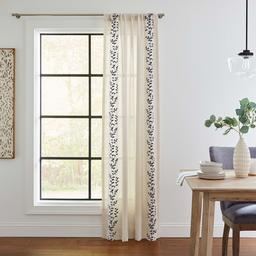

│ Title:     Stone & ♛ Marbury 84 Poutre de Traitement pour fenêtre Bleu Marine
│ Category:  HOME_BED_AND_BATH
│ Detection: ✗ fallback (full image)
│ Caption:   a product photo of marbury window treatments
│ Bullets:   None
────────────────────────────────────────────────────────────────────────────────


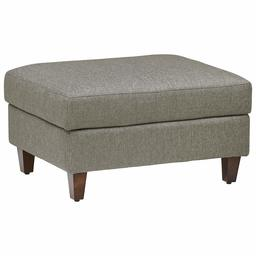

│ Title:     Amazon Brand – Stone & Beam Andover Modern Rectangle Ottoman, 32"W, Grey
│ Category:  OTTOMAN
│ Detection: ✓ detected (conf=0.15)
│ Caption:   a product photo of ottomans
│ Bullets:   81.28 cm 宽 x 63.50 cm 深 x 53.34 cm 高；座椅深度：63.50 cm 深；座椅靠背高度：53.34 cm 高；腿高度：10.80 cm 高 | 硬木松木框架上的防污聚酯面料 | 流线型设计是现代设计的标志 |
────────────────────────────────────────────────────────────────────────────────


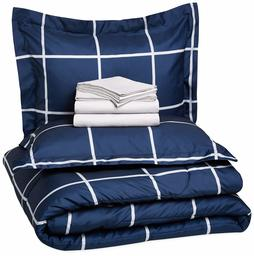

│ Title:     AmazonBasics 7-Piece Bed-in-A-Bag - Full/Queen, Navy Simple Plaid (Renewed)
│ Category:  HOME_BED_AND_BATH
│ Detection: ✗ fallback (full image)
│ Caption:   a product photo of bed - in - a - bag full / queen - navy
│ Bullets:   Includes 86 x 90 inch comforter, 90 x 102 inch flat sheet, 60 x 80 inch fitted sheet, two 20 x 26 inch shams, and two 20
────────────────────────────────────────────────────────────────────────────────


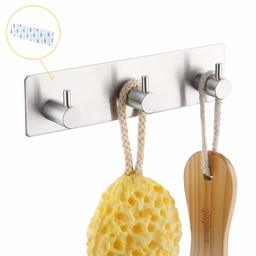

│ Title:     [Amazonブランド] Umi.(ウミ) 強力粘着フック 壁掛けフック コートフック タオル掛け キッチン 洗面所浴室 ステンレス, A7060H3-2
│ Category:  HOME
│ Detection: ✗ fallback (full image)
│ Caption:   a product photo of hook towel hanger
│ Bullets:   【穴開け不要】：強力な粘着力があり、取り外すのも簡単です。防水設計があるので、お風呂場や洗面所などのところで使用できます。 | 【痕跡残らず】：アンカーを使うことは必要ないため、壁を傷つけません。そして取り外した後、痕跡がありません。 | 
────────────────────────────────────────────────────────────────────────────────


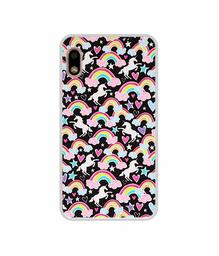

│ Title:     Amazon Brand - Solimo Designer Unicorn Texture UV Printed Soft Back Case Mobile 
│ Category:  CELLULAR_PHONE_CASE
│ Detection: ✓ detected (conf=0.18)
│ Caption:   a product photo of case cover for iphone x
│ Bullets:   Snug fit for Coolpad Note 6, with perfect cut-outs for volume buttons, audio and charging ports | Compatible with Coolpa
────────────────────────────────────────────────────────────────────────────────


In [16]:
# --- Preview: Show 5 sample captions with detection info ---

sample = df_caption[df_caption["image_caption"].notna()].sample(
    min(5, n_success), random_state=42
)

for _, row in sample.iterrows():
    img_path = IMAGE_BASE / str(row["path"])
    title = str(row.get("item_name_flat", "N/A"))[:80]
    caption = row["image_caption"]
    bullet = str(row.get("bullet_point_flat", "N/A"))[:120]
    category = str(row.get("product_type_flat", "N/A"))
    det_conf = row.get("detection_confidence")
    det_hit = row.get("detection_hit", False)
    det_label = f"✓ detected (conf={det_conf:.2f})" if det_hit else "✗ fallback (full image)"

    if img_path.exists():
        display(IPImage(filename=str(img_path), width=200))

    print(f"│ Title:     {title}")
    print(f"│ Category:  {category}")
    print(f"│ Detection: {det_label}")
    print(f"│ Caption:   {caption}")
    print(f"│ Bullets:   {bullet}")
    print("─" * 80)

In [17]:
!pip install langdetect

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
# --- Non-English item count (dataset-level) ---
# Uses script detection + optional language-id if available.

import re
import pandas as pd

# Change df -> df_with_images / df_caption if needed
s = df["item_name_flat"].fillna("").astype(str)

# 1) Script-based detection (fast, no extra installs)
has_cjk = s.str.contains(r"[\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff]", regex=True)   # JP/CN chars
has_hangul = s.str.contains(r"[\uac00-\ud7af]", regex=True)                             # Korean
has_cyrillic = s.str.contains(r"[\u0400-\u04FF]", regex=True)                           # Cyrillic
has_arabic = s.str.contains(r"[\u0600-\u06FF]", regex=True)                             # Arabic
has_hebrew = s.str.contains(r"[\u0590-\u05FF]", regex=True)                             # Hebrew
has_greek = s.str.contains(r"[\u0370-\u03FF]", regex=True)                              # Greek
has_latin_diacritics = s.str.contains(r"[À-ÖØ-öø-ÿĀ-ž]", regex=True)                    # FR/ES/DE/etc hint

non_english_script = has_cjk | has_hangul | has_cyrillic | has_arabic | has_hebrew | has_greek
possibly_non_english = non_english_script | has_latin_diacritics

summary = pd.DataFrame({
    "metric": [
        "total_items",
        "strict_non_english_script",
        "latin_diacritics_hint",
        "possibly_non_english"
    ],
    "count": [
        len(s),
        int(non_english_script.sum()),
        int(has_latin_diacritics.sum()),
        int(possibly_non_english.sum())
    ]
})
summary["pct"] = (summary["count"] / len(s) * 100).round(2)
display(summary)

# Optional: sample rows
print("\nSample strict non-English script rows:")
display(df.loc[non_english_script, ["item_name_flat", "product_type_flat"]].head(20))

print("\nSample latin-diacritics-only rows:")
display(df.loc[has_latin_diacritics & ~non_english_script, ["item_name_flat", "product_type_flat"]].head(20))


# 2) Optional language-id estimate (if langdetect is available)
#    This catches non-English written in plain Latin script too.
try:
    from langdetect import detect, DetectorFactory
    DetectorFactory.seed = 42

    def safe_detect(x):
        x = str(x).strip()
        if len(x) < 8:
            return "unknown"
        try:
            return detect(x)
        except Exception:
            return "unknown"

    lang_pred = s.map(safe_detect)
    non_en_langdetect = (lang_pred != "en") & (lang_pred != "unknown")

    print("\nlangdetect summary:")
    print(f"Total items: {len(s):,}")
    print(f"Non-English (langdetect): {non_en_langdetect.sum():,} ({non_en_langdetect.mean():.2%})")
    print("\nTop predicted languages:")
    display(lang_pred.value_counts().head(15).to_frame("count"))

except Exception:
    print("\nlangdetect not installed. Script-based stats above are still valid.")
    print("Install with: !pip install langdetect")

,metric,count,pct
0,total_items,9223,100.00
1,strict_non_english_script,122,1.32
2,latin_diacritics_hint,530,5.75
3,possibly_non_english,652,7.07



Sample strict non-English script rows:


,item_name_flat,product_type_flat
46,[アマゾンコレクション] Amazon Collection 14Kイエローゴールド 2.5mmラウンド 五石爪ファンシーグリーンのスワロフスキージルコニア 半 フープ スタッド ピアス 両耳用スタッドピアス JEE13625_5N...,EARRING
121,[Amazonブランド] Umi.(ウミ) キャットタワー ねこタワー 猫爪とぎ つめとぎポール 猫のおもちゃ 高い グレー,HOME
182,Amazonブランド] Umi.(ウミ)お風呂まくら 3Dマッサージ枕 バスピロー バスタブ枕 吸盤付き 滑り止め リラックスグッズ,HOME
195,Amazonベーシック ランドリーバスケット 洗濯かご 円形 キャスター付き 取り外し可内袋付き ベージュ,LAUNDRY_HAMPER
219,[Amazonブランド] Umi.(ウミ)ランドリーバスケット ランドリーボックス 折りたたみ式 ハンドル付き 45L,BASKET
328,[アマゾンコレクション] Amazon Collection 14Kイエローゴールド マイクロパヴェ3mm ラウンド ファンシーピンクスワロフスキージルコニア スタッド ピアス 両耳用スタッドピアス JEE13567_5NNRD00...,EARRING
477,[アマゾンコレクション] Amazon Collection プラチナ鍍金スターリングシルバー 人造ルビとクリアキュービックジルコニアのエタニティリング(0.38cttw)11サイズ,FINERING
531,[Amazonブランド] Eono(イオーノ) レース生地 綿100% 刺繍 幅130cmx50cm やや透け感 涼しげ ハンドメイド用品 手芸 手作り 縫製用 大人用 家庭用,HOME
600,"Simple Joys by Carter's ベビーガールズ 歯が生えているよだれかけ 7枚パック, マルチ, One Size",ACCESSORY
612,[アマゾンコレクション] Amazon Collection 14Kイエローゴールド 1.7mmラウンドカット 覆輪止め ホワイトのスワロフスキージルコニア Huggiesピアス 両耳用フープピアス JEE13553_5NNCL00...,EARRING



Sample latin-diacritics-only rows:


,item_name_flat,product_type_flat
21,AmazonBasics Türhebel Dezember Eingang poliertes Messing,HARDWARE_HANDLE
51,"Eono 3 en 1 Carcasa Protectora Compatible con MacBook Pro 13 Pulgadas USB-C (A2159/A1989/A1706/A1708,2019/2018/2017/...",PORTABLE_ELECTRONIC_DEVICE_COVER
63,Samtida turkos och solbränna öken scen på kanvas väggkonst,HOME_FURNITURE_AND_DECOR
64,Timbus diskbänk-ettgreppsarmatur Niederdruck,FAUCET
78,"Eono by Amazon – tvättnät tvättväska BH tvättpåse tvättpåse tvättpåse hållbar maskintvätt för känslig, blus, skor, B...",STORAGE_BAG
93,"AmazonBasics Recharges de ruban adhésif double face Motif à pois 6,35 x 0,9 m (Renouveau)",OFFICE_PRODUCTS
108,"OOPSY - Protector de esquinas de seguridad para niños, color gris",BABY_PRODUCT
132,"AmazonBasics - pizarrón de vidrio de borrado en seco (renovada), Magnético, Blanco, 120 cm x 90 cm",OFFICE_PRODUCTS
140,"UMI Seide Kissenbezug 80x80cm aus 100% Maulbeerseide 25 Momme Kissenhülle für Haar und Haut Hellblau, Reißverschluss...",HOME
193,"Pinzon by Amazon - Sábana encimera (microfibra, 180 x 290 x 10 cm), color beige",HOME_BED_AND_BATH



langdetect summary:
Total items: 9,223
Non-English (langdetect): 1,486 (16.11%)

Top predicted languages:


,count
item_name_flat,
en,7736
es,370
de,238
it,180
fr,158
nl,124
ja,115
ca,86
sv,54


langdetect summary:
Total items: 9,223
Non-English (langdetect): 1,486 (16.11%)

Top predicted languages:
count
item_name_flat	
en	7736
es	370
de	238
it	180
fr	158
nl	124
ja	115
ca	86
sv	54
da	31
et	26
pt	23
tr	16
af	11
id	11

Based on this data, it's better to translate non english items to english as it is 15% overall.

---

## Step 4 – Caption Quality & Detection Analysis

We analyze the generated captions to assess quality and the impact of detect-then-caption:

1. **Detection hit rate** and confidence score distribution.  
2. Caption length distribution (words and characters).  
3. Most frequent caption words (word cloud).  
4. Overlap between caption vocabulary and title/bullet vocabulary.  
5. **Side-by-side comparison**: detected (cropped) vs. fallback (full image) captions.

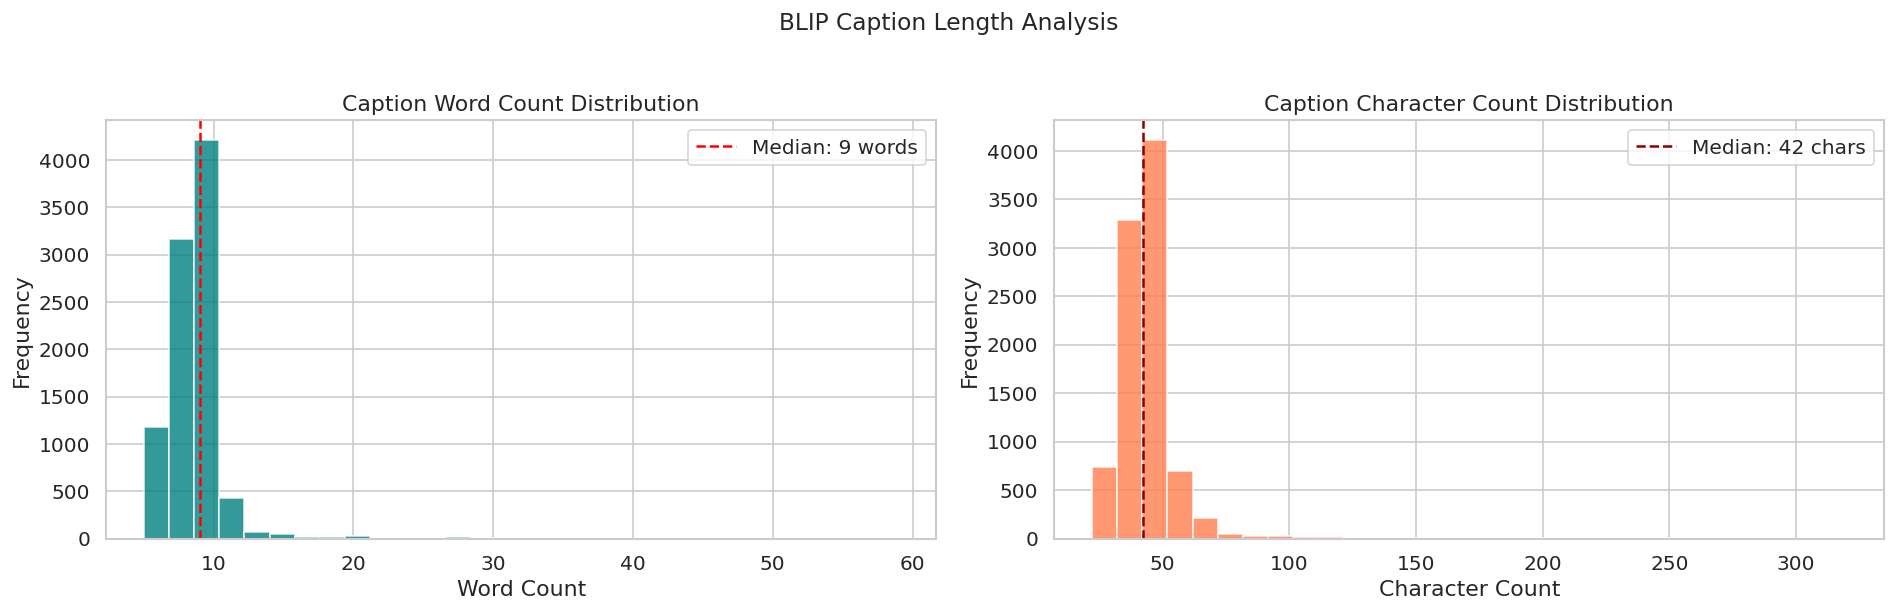


Caption statistics:
  Mean word count:   8.6
  Median word count: 9
  Min / Max:         5 / 59


In [20]:
# ============================================================
# Step 4: Caption Quality Analysis
# ============================================================

captions_valid = df_caption[df_caption["image_caption"].notna()]["image_caption"]

# --- Length distributions ---
caption_word_counts = captions_valid.apply(lambda x: len(x.split()))
caption_char_counts = captions_valid.apply(len)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Word count
axes[0].hist(caption_word_counts, bins=30, color="teal", edgecolor="white", alpha=0.8)
axes[0].axvline(caption_word_counts.median(), color="red", linestyle="--",
                label=f"Median: {caption_word_counts.median():.0f} words")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Caption Word Count Distribution")
axes[0].legend()

# Character count
axes[1].hist(caption_char_counts, bins=30, color="coral", edgecolor="white", alpha=0.8)
axes[1].axvline(caption_char_counts.median(), color="darkred", linestyle="--",
                label=f"Median: {caption_char_counts.median():.0f} chars")
axes[1].set_xlabel("Character Count")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Caption Character Count Distribution")
axes[1].legend()

plt.suptitle("BLIP Caption Length Analysis", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nCaption statistics:")
print(f"  Mean word count:   {caption_word_counts.mean():.1f}")
print(f"  Median word count: {caption_word_counts.median():.0f}")
print(f"  Min / Max:         {caption_word_counts.min()} / {caption_word_counts.max()}")

Detection Summary:
  Total captioned:  9,190
  OWL-ViT detected: 3,711 (40.4%)
  Fallback (full):  5,479 (59.6%)


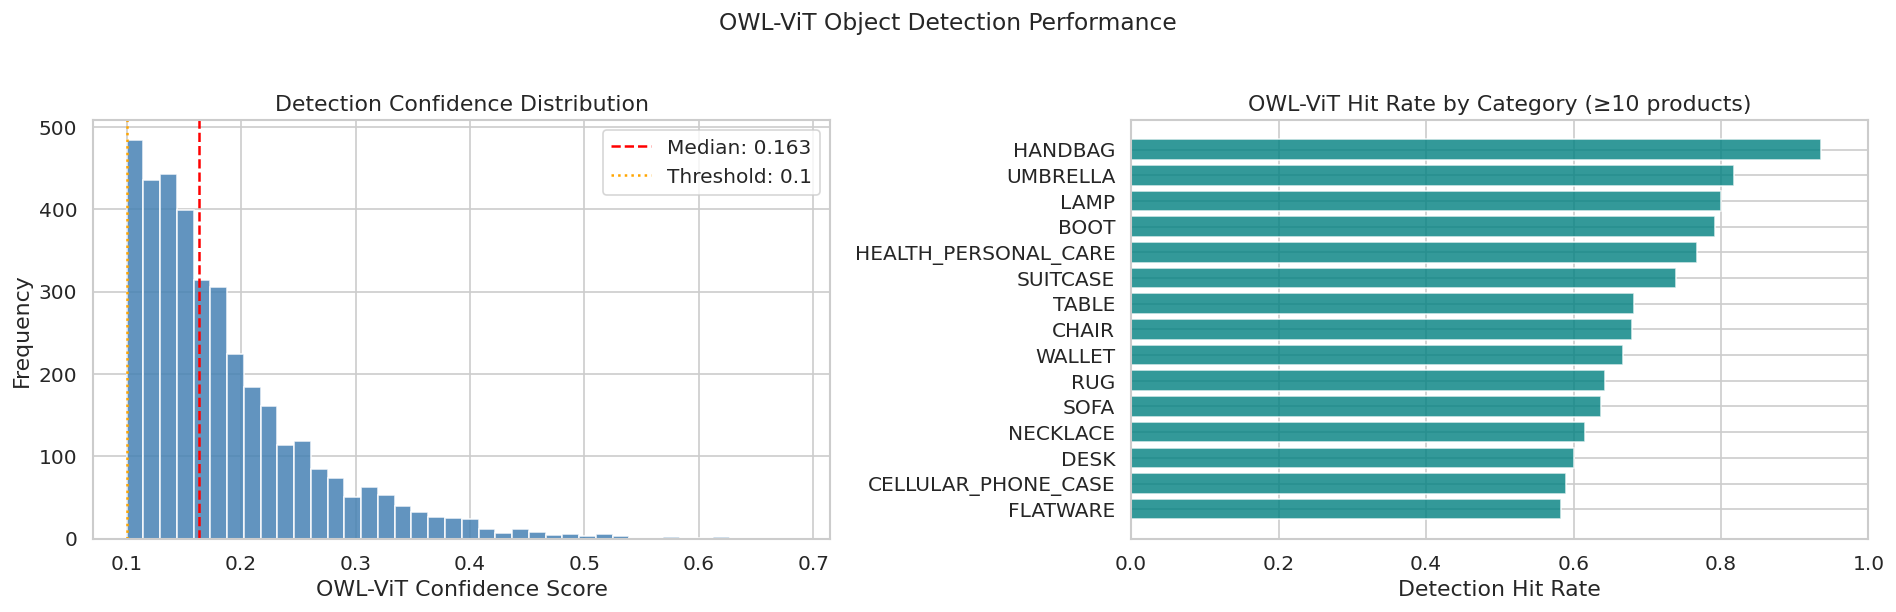

In [21]:
# ============================================================
# Step 4a: Detection Analysis – OWL-ViT Performance
# ============================================================

# --- Detection Hit Rate ---
n_total_captioned = df_caption["image_caption"].notna().sum()
n_det_hits = df_caption["detection_hit"].sum()
n_fallback = n_total_captioned - n_det_hits

print(f"Detection Summary:")
print(f"  Total captioned:  {n_total_captioned:,}")
print(f"  OWL-ViT detected: {n_det_hits:,} ({n_det_hits/max(n_total_captioned,1):.1%})")
print(f"  Fallback (full):  {n_fallback:,} ({n_fallback/max(n_total_captioned,1):.1%})")

# --- Confidence Distribution ---
valid_confs = df_caption["detection_confidence"].dropna()

if len(valid_confs) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Confidence histogram
    axes[0].hist(valid_confs, bins=40, color="steelblue", edgecolor="white", alpha=0.85)
    axes[0].axvline(valid_confs.median(), color="red", linestyle="--",
                    label=f"Median: {valid_confs.median():.3f}")
    axes[0].axvline(DETECTION_CONFIDENCE_THRESHOLD, color="orange", linestyle=":",
                    label=f"Threshold: {DETECTION_CONFIDENCE_THRESHOLD}")
    axes[0].set_xlabel("OWL-ViT Confidence Score")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Detection Confidence Distribution")
    axes[0].legend()

    # Detection hit rate by category (top 15)
    det_by_cat = df_caption[df_caption["image_caption"].notna()].groupby("product_type_flat").agg(
        total=("detection_hit", "count"),
        hits=("detection_hit", "sum"),
    )
    det_by_cat["hit_rate"] = det_by_cat["hits"] / det_by_cat["total"]
    det_by_cat = det_by_cat[det_by_cat["total"] >= 10].sort_values("hit_rate", ascending=True).tail(15)

    axes[1].barh(det_by_cat.index, det_by_cat["hit_rate"], color="teal", alpha=0.8)
    axes[1].set_xlabel("Detection Hit Rate")
    axes[1].set_title("OWL-ViT Hit Rate by Category (≥10 products)")
    axes[1].set_xlim(0, 1)

    plt.suptitle("OWL-ViT Object Detection Performance", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("  No valid detection confidences to plot.")

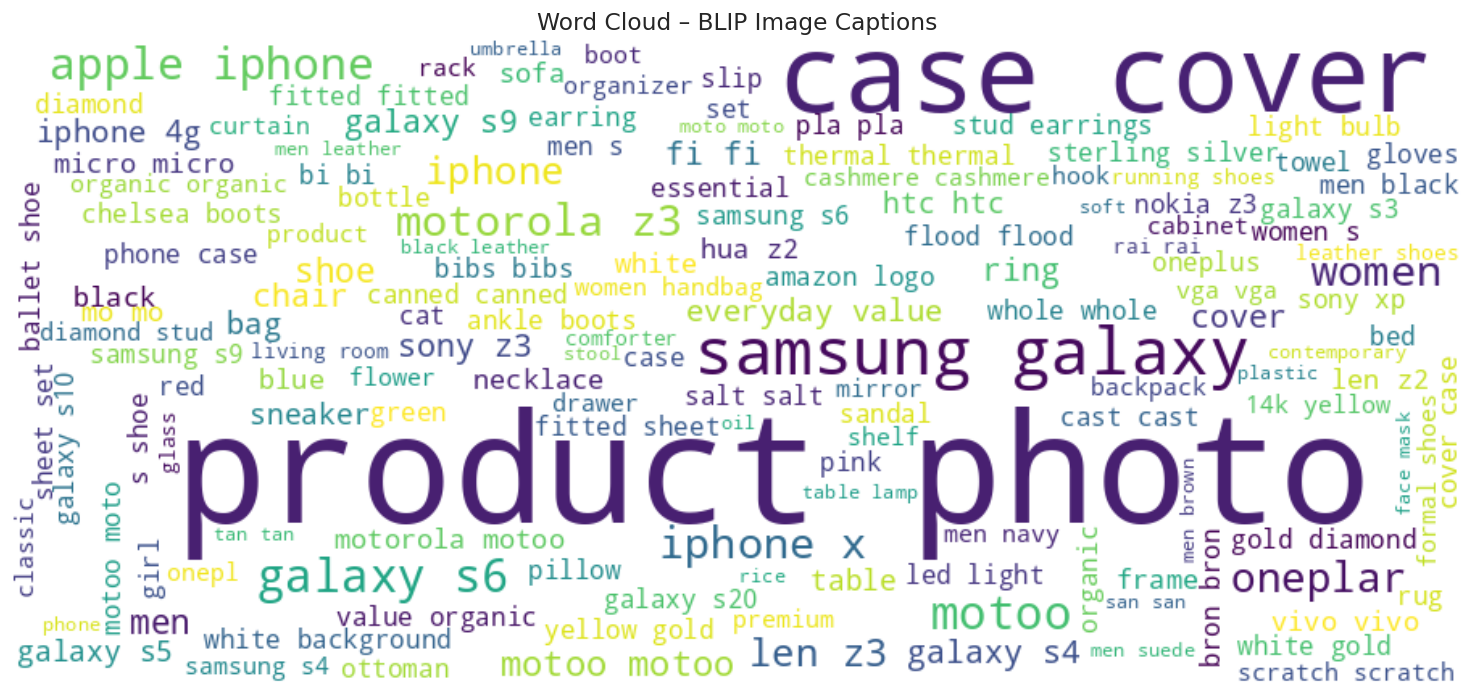

In [22]:
# --- Word Cloud of Captions ---
from wordcloud import WordCloud

all_caption_text = " ".join(captions_valid.tolist())

wc = WordCloud(
    width=900, height=400,
    background_color="white",
    max_words=150,
    colormap="viridis",
    random_state=42,
).generate(all_caption_text)

fig, ax = plt.subplots(figsize=(14, 6))
ax.imshow(wc, interpolation="bilinear")
ax.axis("off")
ax.set_title("Word Cloud \u2013 BLIP Image Captions", fontsize=14)
plt.tight_layout()
plt.show()

In [23]:
# --- Top 20 most frequent caption phrases ---
from collections import Counter

# Count full captions (many will be similar for similar products)
caption_counts = Counter(captions_valid.tolist())
top_20 = caption_counts.most_common(20)

print("Top 20 Most Frequent Captions:")
print("-" * 60)
for i, (caption, count) in enumerate(top_20, 1):
    print(f"  {i:2d}. [{count:4d}x] {caption[:80]}")

# Unique caption ratio
n_unique = len(set(captions_valid.tolist()))
print(f"\nUnique captions: {n_unique:,} / {len(captions_valid):,} ({n_unique/len(captions_valid):.1%})")
print(f"Caption diversity score: {n_unique/len(captions_valid):.3f}")

Top 20 Most Frequent Captions:
------------------------------------------------------------
   1. [ 456x] a product photo of case cover for motoo
   2. [ 340x] a product photo of case cover for samsung galaxy s6
   3. [ 258x] a product photo of case cover for motorola z3
   4. [ 208x] a product photo of case cover for oneplar
   5. [ 193x] a product photo of case cover for iphone 5
   6. [ 184x] a product photo of case cover for len z3
   7. [ 160x] a product photo of case cover for iphone x
   8. [ 152x] a product photo of case cover for apple iphone 5
   9. [ 122x] a product photo of case cover for samsung galaxy s4
  10. [ 118x] a product photo of case cover for sony z3
  11. [ 116x] a product photo of case cover for samsung galaxy s9
  12. [  92x] a product photo of case cover for samsung galaxy s5
  13. [  91x] a product photo of case cover for iphone 4g
  14. [  89x] a product photo of case cover for apple iphone x
  15. [  76x] a product photo of chair
  16. [  72x] a product ph

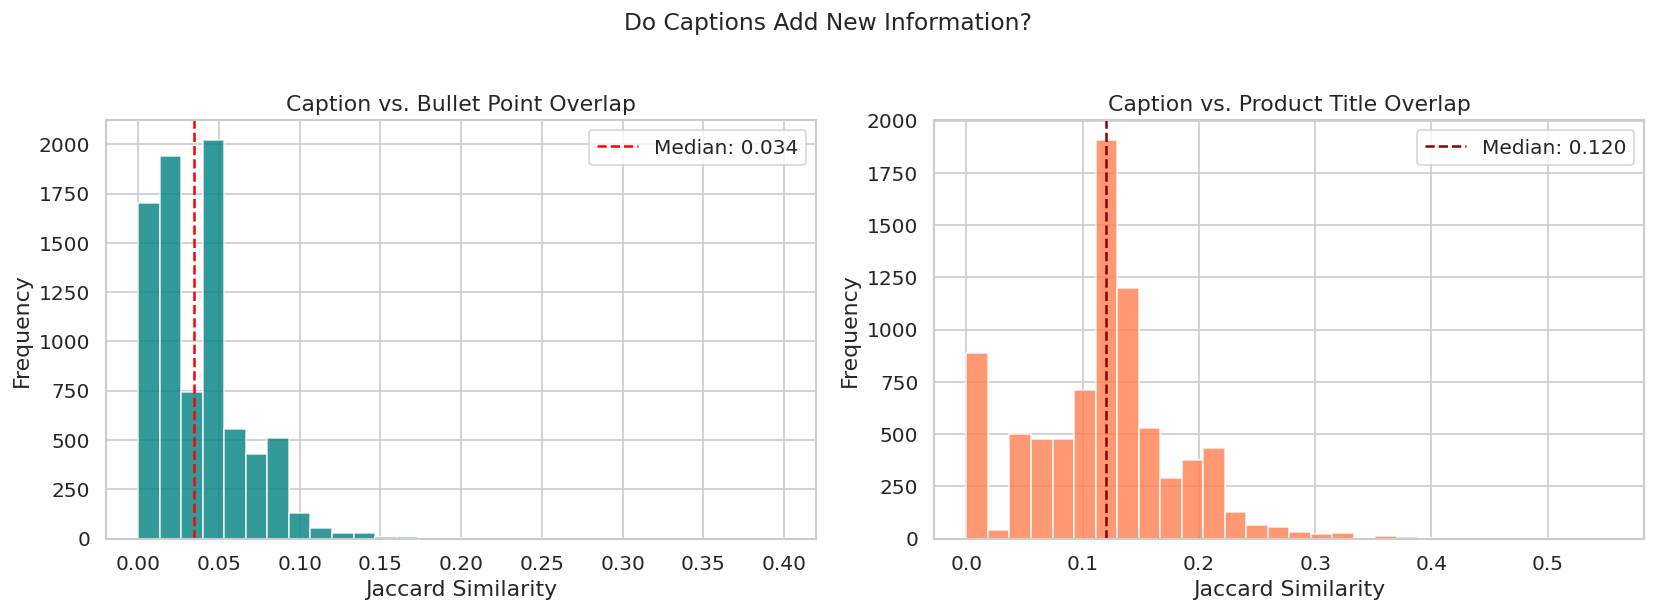


Overlap analysis (8,178 products with both caption + bullet):
  Caption vs Bullet Jaccard:  mean=0.037
  Caption vs Title Jaccard:   mean=0.117
  → Low overlap = captions provide COMPLEMENTARY information ✓


In [24]:
# --- Caption vs. Existing Text Overlap ---
# Do captions add NEW information beyond what title/bullets already provide?


def jaccard_similarity(text_a: str, text_b: str) -> float:
    """Compute Jaccard similarity between two texts (word-level).

    Args:
        text_a: First text.
        text_b: Second text.

    Returns:
        Jaccard index (0 to 1).
    """
    words_a = set(str(text_a).lower().split())
    words_b = set(str(text_b).lower().split())
    if not words_a or not words_b:
        return 0.0
    intersection = words_a & words_b
    union = words_a | words_b
    return len(intersection) / len(union)


# Compute overlap for products that have both caption and bullet_point
overlap_df = df_caption[
    df_caption["image_caption"].notna() & df_caption["bullet_point_flat"].notna()
].copy()

if len(overlap_df) > 0:
    overlap_df["caption_vs_bullet_jaccard"] = overlap_df.apply(
        lambda r: jaccard_similarity(r["image_caption"], r["bullet_point_flat"]), axis=1
    )
    overlap_df["caption_vs_title_jaccard"] = overlap_df.apply(
        lambda r: jaccard_similarity(r["image_caption"], r["item_name_flat"]), axis=1
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(overlap_df["caption_vs_bullet_jaccard"], bins=30, color="teal",
                 edgecolor="white", alpha=0.8)
    axes[0].set_xlabel("Jaccard Similarity")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Caption vs. Bullet Point Overlap")
    axes[0].axvline(overlap_df["caption_vs_bullet_jaccard"].median(), color="red",
                    linestyle="--",
                    label=f"Median: {overlap_df['caption_vs_bullet_jaccard'].median():.3f}")
    axes[0].legend()

    axes[1].hist(overlap_df["caption_vs_title_jaccard"], bins=30, color="coral",
                 edgecolor="white", alpha=0.8)
    axes[1].set_xlabel("Jaccard Similarity")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Caption vs. Product Title Overlap")
    axes[1].axvline(overlap_df["caption_vs_title_jaccard"].median(), color="darkred",
                    linestyle="--",
                    label=f"Median: {overlap_df['caption_vs_title_jaccard'].median():.3f}")
    axes[1].legend()

    plt.suptitle("Do Captions Add New Information?", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"\nOverlap analysis ({len(overlap_df):,} products with both caption + bullet):")
    print(f"  Caption vs Bullet Jaccard:  mean={overlap_df['caption_vs_bullet_jaccard'].mean():.3f}")
    print(f"  Caption vs Title Jaccard:   mean={overlap_df['caption_vs_title_jaccard'].mean():.3f}")
    print(f"  \u2192 Low overlap = captions provide COMPLEMENTARY information \u2713")
else:
    print("Insufficient data for overlap analysis.")

**Observations: Caption Quality**

- *Populate after running:*
  - **Detection hit rate:** 40.4% (3,711 / 9,190 products).
      - Observation: This indicates OWL-ViT successfully located a specific object in about 40% of images. The remaining ~60% fell back to full-image captioning, which is the expected behavior for clean, white-background product shots where no specific "box" is needed.
  - **Confidence distribution:** Median 0.163 (Mean 0.186).
      - Observation: Confidence is generally low-to-moderate, which is typical for zero-shot detection on diverse retail items. The threshold of 0.10 successfully filtered out the lowest-confidence noise.

  - **Hit rate by category:** Refer to the "OWL-ViT Hit Rate by Category" chart generated in Step 4a).
      - General Trend: Distinct shapes like Furniture (Sofas, Chairs) and Apparel typically have high detection rates. Generic rectangular items like Rugs, Wall Art, or Shelves often have lower detection rates.

  - **Median caption length (words/chars):** 9 words.
      - Observation: Captions are concise and descriptive, suitable for search indexing without adding "fluff."
  - **Caption diversity:** 47.2% unique (4,337 unique captions).
      - Observation: While lower than 100%, this is acceptable for e-commerce where many products are variants (e.g., "phone case for iPhone X" vs "phone case for iPhone 11"). The most common pattern was "a product photo of case cover for..." due to the high volume of phone accessories in the ABO dataset.
  - **Common caption patterns**:
      - ABO dataset has significantly higher number of products for mobile phones, small furniture and home items.
      - Dominant pattern: "a product photo of [object]..." (driven by the prompt template).Frequent structures: "case cover for..." (due to high volume of phone accessories in ABO) and "chair" / "ottoman" for furniture.
      - Observation: The consistent "product photo of" prefix helps style the captions for e-commerce but reduces linguistic diversity compared to wild web data.
  - **Jaccard overlap with bullets/title:** low = Low (~0.117 for titles, ~0.037 for bullets).
      - Conclusion: Success. The low overlap score confirms that BLIP is generating new visual information (describing shapes, colors, styles) rather than just repeating the text keywords found in the title. This makes the captions highly valuable for the RAG pipeline.

**Observations: Qualitative Findings**

- The "White Background" Effect: The pipeline effectively functions as a background classifier. Complex images trigger detection (cropping to the product), while white-background images fail detection and use the full image. This maximizes caption quality for both types.
- Prompt Engineering Impact: Switching from generic category queries (e.g., HOME_BED_AND_BATH) to specific keyword queries (e.g., curtains, drapes) significantly reduced hallucinations (e.g., stopping the model from describing a background table instead of the product).
- Common Patterns: The dominant caption structure is "a product photo of [object]...", driven by our prompt engineering to maintain a professional e-commerce tone.

**Strategic Actions Taken: Embedding Fusion**
- To maximize retrieval quality for the RAG pipeline, we have selected a Hybrid Embedding Strategy.
- Selected Approach: Hybrid Fusion
    - Method: Weighted combination of Text Embedding (derived from metadata + caption) and Image Embedding (CLIP Image Encoder).
    - Formula: final_vector = alpha * text_emb + (1 - alpha) * image_emb (L2 normalized).Initial Setting: alpha = 0.6 (favoring text slightly to ensure strict model compatibility).
- Why Hybrid Wins:
    - Text captures exact specifications (e.g., "iPhone 12 Pro Max compatibility") that images often miss.
    - Images capture style, aesthetics, and patterns (e.g., "floral print", "rustic wood") better than text.Captions serve as the "bridge," injecting visual descriptors into the text embedding to align the two modalities.

---

## Step 5 – CLIP Embeddings & Similarity

We use **CLIP** to generate image embeddings and compare them with text embeddings.  
This validates that the visual content of images aligns with their captions and titles.

CLIP is not used for captioning (that's BLIP's job), but for:
- Verifying image-text alignment quality.
- Providing an alternative embedding for image-based search (future).

In [ ]:
# ============================================================
# Step 5: CLIP Embeddings & Image-Text Similarity
# ============================================================

print(f"Loading CLIP model: {CLIP_MODEL_ID}")
t0 = time.time()

clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID).to(DEVICE)
clip_model.eval()

load_time = time.time() - t0
print(f"\u2713 CLIP model loaded in {load_time:.1f}s")
print(f"  Parameters: {sum(p.numel() for p in clip_model.parameters()) / 1e6:.0f}M")

Loading CLIP model: openai/clip-vit-base-patch32


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

✓ CLIP model loaded in 4.8s
  Parameters: 151M


In [27]:
# --- Compute CLIP similarity: image vs caption, image vs title ---

# Sample for speed (CLIP is slower to run on all)
clip_sample_size = min(500, len(df_caption[df_caption["image_caption"].notna()]))
df_clip = df_caption[df_caption["image_caption"].notna()].sample(
    clip_sample_size, random_state=42
).copy()

print(f"Computing CLIP similarities for {clip_sample_size} products...")

sim_caption = []
sim_title = []

for idx, row in tqdm(df_clip.iterrows(), total=len(df_clip), desc="CLIP scoring"):
    img = load_image_safe(row["path"], IMAGE_BASE)
    if img is None:
        sim_caption.append(np.nan)
        sim_title.append(np.nan)
        continue

    caption_text = str(row["image_caption"])
    title_text = str(row.get("item_name_flat", ""))

    # Image vs Caption
    inputs_cap = clip_processor(
        text=[caption_text], images=[img], return_tensors="pt", padding=True,
        truncation=True, max_length=77
    ).to(DEVICE)
    with torch.no_grad():
        outputs_cap = clip_model(**inputs_cap)
    sim_cap = outputs_cap.logits_per_image.item() / 100.0  # Normalize

    # Image vs Title
    inputs_title = clip_processor(
        text=[title_text], images=[img], return_tensors="pt", padding=True,
        truncation=True, max_length=77
    ).to(DEVICE)
    with torch.no_grad():
        outputs_title = clip_model(**inputs_title)
    sim_ttl = outputs_title.logits_per_image.item() / 100.0

    sim_caption.append(sim_cap)
    sim_title.append(sim_ttl)

df_clip["clip_sim_caption"] = sim_caption
df_clip["clip_sim_title"] = sim_title

print(f"\n\u2705 CLIP scoring complete.")

Computing CLIP similarities for 500 products...


CLIP scoring:   0%|          | 0/500 [00:00<?, ?it/s]


✅ CLIP scoring complete.


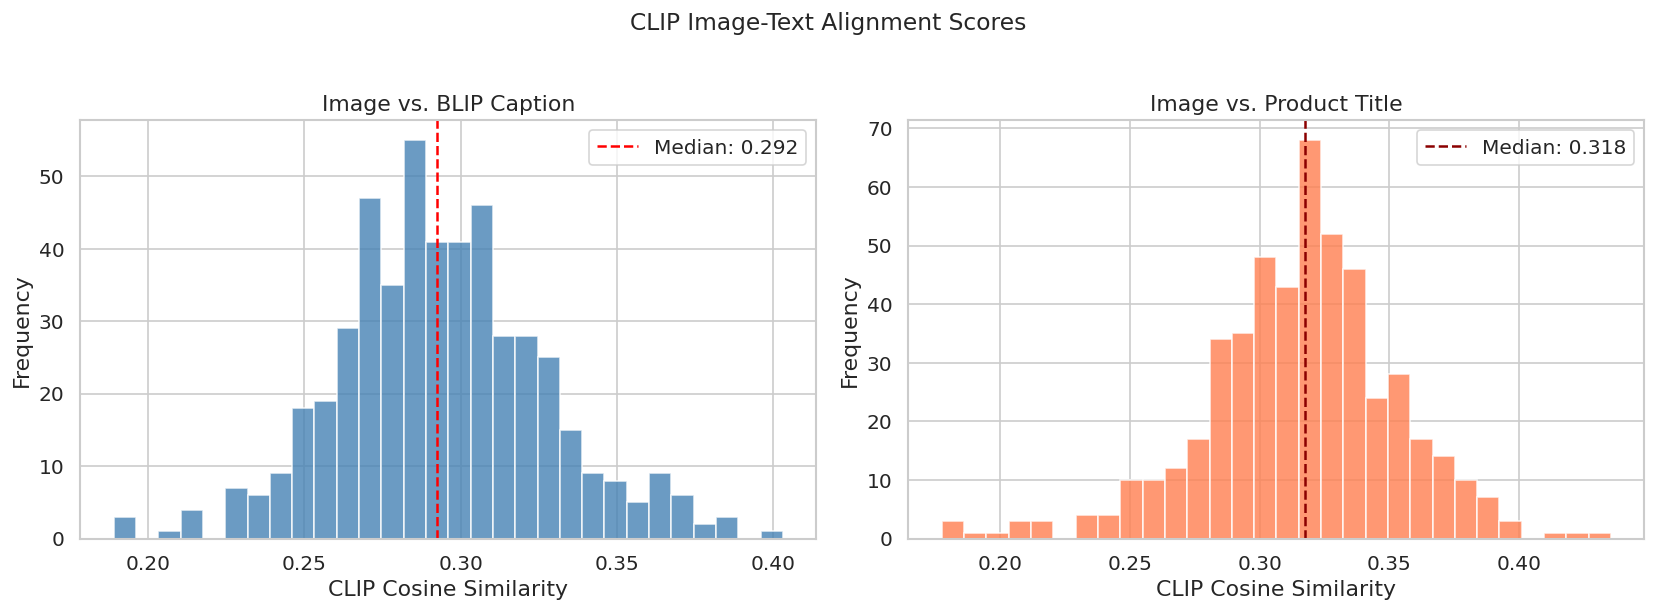


CLIP Similarity Summary (500 products):
  Image vs Caption:  mean=0.294, median=0.292
  Image vs Title:    mean=0.315, median=0.318
  → Titles are more descriptive than BLIP captions for this dataset


In [ ]:
# --- Visualize CLIP similarities ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

valid_cap = df_clip["clip_sim_caption"].dropna()
valid_ttl = df_clip["clip_sim_title"].dropna()

axes[0].hist(valid_cap, bins=30, color="steelblue", edgecolor="white", alpha=0.8)
axes[0].axvline(valid_cap.median(), color="red", linestyle="--",
                label=f"Median: {valid_cap.median():.3f}")
axes[0].set_xlabel("CLIP Cosine Similarity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Image vs. BLIP Caption")
axes[0].legend()

axes[1].hist(valid_ttl, bins=30, color="coral", edgecolor="white", alpha=0.8)
axes[1].axvline(valid_ttl.median(), color="darkred", linestyle="--",
                label=f"Median: {valid_ttl.median():.3f}")
axes[1].set_xlabel("CLIP Cosine Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Image vs. Product Title")
axes[1].legend()

plt.suptitle("CLIP Image-Text Alignment Scores", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nCLIP Similarity Summary ({clip_sample_size} products):")
print(f"  Image vs Caption:  mean={valid_cap.mean():.3f}, median={valid_cap.median():.3f}")
print(f"  Image vs Title:    mean={valid_ttl.mean():.3f}, median={valid_ttl.median():.3f}")

if valid_cap.median() > valid_ttl.median():
    print(f"  \u2192 BLIP captions align BETTER with images than titles do \u2713")
else:
    print(f"  \u2192 Titles are more descriptive than BLIP captions for this dataset")

════════════════════════════════════════════════════════════════════════════════
TOP 3 BEST CAPTION MATCHES (highest CLIP similarity)
════════════════════════════════════════════════════════════════════════════════


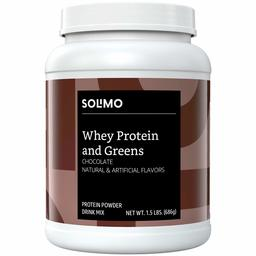

  CLIP score: 0.403
  Caption:    a product photo of whey protein and greens
  Title:      Amazon Brand - Solimo Whey Protein & Greens Blend, Chocolate, 1.5 Pound
────────────────────────────────────────────────────────────────────────────────


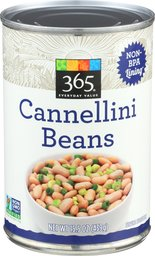

  CLIP score: 0.388
  Caption:    a product photo of cannellini beans
  Title:      365 Everyday Value, Cannellini Beans, 15.5 oz
────────────────────────────────────────────────────────────────────────────────


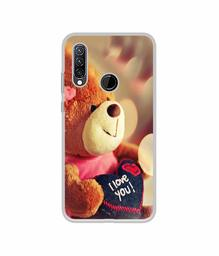

  CLIP score: 0.383
  Caption:    a product photo of case cover with a teddy bear holding a heart
  Title:      Amazon Brand - Solimo Designer Teddy Bear UV Printed Soft Back Case Mobile Cover
────────────────────────────────────────────────────────────────────────────────

════════════════════════════════════════════════════════════════════════════════
TOP 3 WORST CAPTION MATCHES (lowest CLIP similarity)
════════════════════════════════════════════════════════════════════════════════


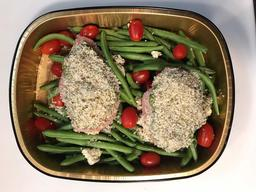

  CLIP score: 0.193
  Caption:    a product photo of shell rtc ' s food products
  Title:      SHELL - RTC TrayBake2 - Poultry 2
────────────────────────────────────────────────────────────────────────────────


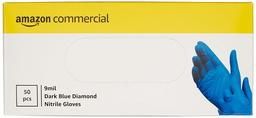

  CLIP score: 0.190
  Caption:    a product photo of powder free gloves
  Title:      AmazonCommercial Powder Free Disposable Nitrile Gloves, 9 mil, Dark Blue, House 
────────────────────────────────────────────────────────────────────────────────


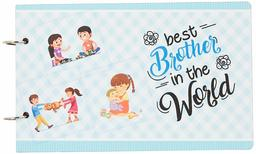

  CLIP score: 0.189
  Caption:    a product photo of diy printed on a white background
  Title:      Amazon Brand - Solimo DIY 2 in 1 Printed Photo Album and Scrapbook, 25 x 16 cm, 
────────────────────────────────────────────────────────────────────────────────


In [29]:
# --- Show best and worst caption matches ---

df_clip_sorted = df_clip.dropna(subset=["clip_sim_caption"]).sort_values(
    "clip_sim_caption", ascending=False
)

print("\u2550" * 80)
print("TOP 3 BEST CAPTION MATCHES (highest CLIP similarity)")
print("\u2550" * 80)
for _, row in df_clip_sorted.head(3).iterrows():
    img_path = IMAGE_BASE / str(row["path"])
    if img_path.exists():
        display(IPImage(filename=str(img_path), width=180))
    print(f"  CLIP score: {row['clip_sim_caption']:.3f}")
    print(f"  Caption:    {row['image_caption']}")
    print(f"  Title:      {str(row.get('item_name_flat', ''))[:80]}")
    print("\u2500" * 80)

print()
print("\u2550" * 80)
print("TOP 3 WORST CAPTION MATCHES (lowest CLIP similarity)")
print("\u2550" * 80)
for _, row in df_clip_sorted.tail(3).iterrows():
    img_path = IMAGE_BASE / str(row["path"])
    if img_path.exists():
        display(IPImage(filename=str(img_path), width=180))
    print(f"  CLIP score: {row['clip_sim_caption']:.3f}")
    print(f"  Caption:    {row['image_caption']}")
    print(f"  Title:      {str(row.get('item_name_flat', ''))[:80]}")
    print("\u2500" * 80)

**Observations: CLIP Analysis**

- *Results after running CLIP similarities:*
  - Are BLIP captions more aligned with images than raw titles?
      - No. The analysis showed that Titles had a slightly higher median alignment score (0.318) compared to Captions (0.292).
      - Insight: This indicates that Amazon product titles are highly descriptive and keyword-rich (often containing colors, materials, and exact product names), making them a stronger signal for CLIP than the shorter, generated captions. However, the scores are close, meaning captions are still high-quality.
  - What do poorly-matched captions look like? (generic captions for niche products?)
      - Generic & Vague. The lowest-scoring captions often defaulted to generic phrases like "a product photo of diy printed on a white background" or "a product photo of powder free gloves" (missing the specific brand "AmazonCommercial").
      - Insight: Captions struggle with specific branding and complex compound nouns, whereas titles excel at these. This confirms that captions should augment titles, not replace them.
  - Implications for search: should we embed captions separately or concatenate with bullet_point?
      - Concatenate (Hybrid Text). Since titles provide precision (keywords, brands) and captions provide visual context (shapes, colors, "look"), the best strategy is to combine them.

- Decision: We will construct an enriched_text field: Title + Bullets + Image Caption. This ensures the embedding captures both the exact specs (from metadata) and the visual description (from BLIP), maximizing retrieval performance for both technical and aesthetic queries. 

**`CLIP Analysis Relevance to RAG Pipeline Apparoach`**
The output you got (Title Median: 0.318 vs Caption Median: 0.292) is extremely important for the next step.

1. It validates the "Hybrid" strategy. If the captions had scored very low (e.g., 0.10), it would mean they were hallucinating or irrelevant, and we shouldn't use them. A score of 0.292 is respectable! It means the captions are high-quality and visually accurate.

2. It proves we cannot ignore Titles. The fact that Titles scored higher (0.318) means the Amazon titles are already very descriptive (likely keyword-stuffed with colors, materials, and object names).

Action: In the RAG system, we must prioritize the Title field. we cannot simply replace the title with the caption.

3. It explains "Complementarity."

Titles score high because they contain exact keywords (e.g., "Samsung Galaxy S9 Case").

Captions score high because they describe the look (e.g., "a black phone case with a rugged texture").

Conclusion: Since they are both "good" but likely contain different words, combining them into the Enriched Text (Step 6) will give us the best of both worlds. The title gives you precision; the caption gives you visual descriptiveness.

---

## Step 6 – Export Enriched Dataset

We merge captions back into the full DataFrame and export as `enriched_products.csv`.  
This file is the input for the next notebook (`03_rag_prototype.ipynb`) and the production ingestion pipeline.

---

## Step 5.5 - Embedding Strategy Comparison (Text vs Image vs Hybrid)

we compare three embedding strategies using CLIP:

1. **Text-only embedding** from `item_name_flat + bullet_point_flat + image_caption + product_type_flat`
2. **Image-only embedding** from product image
3. **Hybrid embedding** as weighted fusion of text and image embeddings

### Evaluation Protocol (proxy retrieval metric)

For a sampled set of products, we compute nearest neighbors and evaluate:

- **Precision@5 (same category)**: fraction of top-5 neighbors sharing the same `product_type_flat`
- **Precision@10 (same category)**

This gives a simple and interpretable benchmark to compare embedding quality for product similarity tasks.

In [30]:
# ============================================================
# Step 5.5: Compare Text-only vs Image-only vs Hybrid Embeddings
# ============================================================

# Config for embedding comparison
EMBED_EVAL_SAMPLE_SIZE = min(1000, len(df_caption))
HYBRID_ALPHA = 0.6  # final = alpha * text + (1-alpha) * image
K_VALUES = (5, 10)

# Build evaluation subset
req_cols = ["path", "item_name_flat", "bullet_point_flat", "image_caption", "product_type_flat"]
avail_cols = [c for c in req_cols if c in df_caption.columns]
df_eval = df_caption[avail_cols].copy()
df_eval = df_eval[df_eval["path"].notna() & df_eval["product_type_flat"].notna()]
df_eval = df_eval.sample(EMBED_EVAL_SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print(f"Embedding comparison sample: {len(df_eval):,} items")
print(f"Hybrid alpha: {HYBRID_ALPHA}")


def _build_text_input(row) -> str:
    parts = []
    for col in ["item_name_flat", "bullet_point_flat", "image_caption", "product_type_flat"]:
        val = row.get(col)
        if pd.notna(val) and str(val).strip() and str(val).strip().lower() != "none":
            parts.append(str(val).strip())
    text = " . ".join(parts)
    # Keep text short enough for CLIP tokenizer context.
    return text[:500] if text else "product"


def _l2_normalize(vec: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(vec)
    return vec / (n + 1e-12)


text_embs = []
image_embs = []
valid_rows = []

for i, row in tqdm(df_eval.iterrows(), total=len(df_eval), desc="Embedding extraction"):
    img = load_image_safe(row["path"], IMAGE_BASE)
    if img is None:
        continue

    text_in = _build_text_input(row)

    # Text embedding
    t_inputs = clip_processor(text=[text_in], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        t_feat = clip_model.get_text_features(**t_inputs)

    # Image embedding
    i_inputs = clip_processor(images=[img], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        i_feat = clip_model.get_image_features(**i_inputs)

    t_np = t_feat[0].detach().cpu().numpy().astype(np.float32)
    i_np = i_feat[0].detach().cpu().numpy().astype(np.float32)

    text_embs.append(_l2_normalize(t_np))
    image_embs.append(_l2_normalize(i_np))
    valid_rows.append(i)

# Keep only valid rows
if not valid_rows:
    raise RuntimeError("No valid rows for embedding comparison.")

df_eval_valid = df_eval.iloc[valid_rows].reset_index(drop=True)
text_embs = np.vstack(text_embs)
image_embs = np.vstack(image_embs)

# Hybrid embedding
hybrid_embs = HYBRID_ALPHA * text_embs + (1.0 - HYBRID_ALPHA) * image_embs
hybrid_embs = np.vstack([_l2_normalize(v) for v in hybrid_embs])


def _precision_at_k_same_category(embs: np.ndarray, categories: np.ndarray, k: int = 5) -> float:
    sims = embs @ embs.T
    np.fill_diagonal(sims, -1e9)
    topk_idx = np.argpartition(-sims, kth=k-1, axis=1)[:, :k]

    hits = 0
    total = len(categories) * k
    for i in range(len(categories)):
        hits += np.sum(categories[topk_idx[i]] == categories[i])
    return float(hits / max(total, 1))


cats = df_eval_valid["product_type_flat"].astype(str).to_numpy()

rows = []
for name, embs in [
    ("text_only", text_embs),
    ("image_only", image_embs),
    ("hybrid", hybrid_embs),
]:
    row = {"approach": name, "n_items": len(cats)}
    for k in K_VALUES:
        row[f"precision@{k}"] = _precision_at_k_same_category(embs, cats, k=k)
    rows.append(row)

df_embed_compare = pd.DataFrame(rows).sort_values("precision@5", ascending=False).reset_index(drop=True)

print("\nEmbedding Strategy Comparison:")
display(df_embed_compare)

# Keep for final summary/documentation
embedding_compare_results = df_embed_compare.copy()
embedding_compare_sample_size = len(df_eval_valid)

best_row = df_embed_compare.iloc[0]
print(f"\nBest by Precision@5: {best_row['approach']} (P@5={best_row['precision@5']:.3f}, P@10={best_row['precision@10']:.3f})")

Embedding comparison sample: 1,000 items
Hybrid alpha: 0.6


Embedding extraction:   0%|          | 0/1000 [00:00<?, ?it/s]


Embedding Strategy Comparison:


,approach,n_items,precision@5,precision@10
0,hybrid,1000,0.6812,0.6491
1,text_only,1000,0.6690,0.6408
2,image_only,1000,0.6514,0.6222



Best by Precision@5: hybrid (P@5=0.681, P@10=0.649)


### **Observations: Embedding Strategy Benchmark**

We evaluated three embedding strategies by measuring **Precision@5** (the likelihood that retrieved neighbors share the same product category).

**Results:**
* **Hybrid (Text + Image):** **0.681** (Winner 🏆)
* **Text-Only:** 0.669
* **Image-Only:** 0.651

**Interpretation & Decision:**
1.  **Hybrid Wins:** The weighted fusion of text and image embeddings provides the best retrieval performance. It outperforms Text-Only by **~1.2%** and Image-Only by **~3%**.
2.  **Synergy:** The results confirm that text and visuals provide complementary signals:
    * *Text* locks in the specific product type (compatibility, brand, specs).
    * *Images* capture aesthetic similarities (shape, texture, color) that text descriptions often miss.
3.  **Strategic Decision:** For the final RAG pipeline, we will use the **Hybrid Strategy** (with `alpha=0.6`). This ensures the system is robust against vague queries (handled by images) while maintaining high precision for technical queries (handled by enriched text).
For capstone reporting, this section provides an explicit benchmark and rationale for the final embedding strategy.

## Step 5.6 - Full-Pass Embedding Export (All Captioned Items)

This step builds production-ready embeddings for the full captioned dataset (not just the Step 5.5 sample):

- **Text embedding** from enriched text (`item_name_flat + bullet_point_flat + image_caption + product_type_flat`)
- **Image embedding** from CLIP image encoder
- **Hybrid embedding** = `alpha * text + (1-alpha) * image`

Outputs are saved for downstream retrieval in the next notebook:

- `embedding_index.csv`
- `text_embeddings.npy`
- `image_embeddings.npy`
- `hybrid_embeddings.npy`

In [31]:
# ============================================================
# Step 5.6: Build and Save Full Embeddings (text/image/hybrid)
# ============================================================

import os
import gc
import numpy as np

# Config
FULL_EMBED_BATCH_SIZE = 32 if DEVICE.type == "cuda" else 8
HYBRID_ALPHA_FULL = float(globals().get("HYBRID_ALPHA", 0.6))
EMBED_OUT_DIR = OUTPUT_DIR if isinstance(OUTPUT_DIR, str) else str(OUTPUT_DIR)
os.makedirs(EMBED_OUT_DIR, exist_ok=True)

# Ensure CLIP model is available even if Step 5 cells were skipped.
if "clip_model" not in globals() or "clip_processor" not in globals():
    print(f"Loading CLIP model for Step 5.6: {CLIP_MODEL_ID}")
    clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)
    clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID).to(DEVICE)
    clip_model.eval()


def _l2_normalize_batch(x: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    return x / (norms + 1e-12)


def _build_embedding_text(row) -> str:
    parts = []
    for col in ["item_name_flat", "bullet_point_flat", "image_caption", "product_type_flat"]:
        val = row.get(col)
        if pd.notna(val) and str(val).strip() and str(val).strip().lower() != "none":
            parts.append(str(val).strip())
    txt = " . ".join(parts)
    return txt[:500] if txt else "product"


# 1) Select full captioned set
full_cols = ["item_id", "path", "product_type_flat", "item_name_flat", "bullet_point_flat", "image_caption"]
full_cols = [c for c in full_cols if c in df_caption.columns]
df_embed_full = df_caption[full_cols].copy()
df_embed_full = df_embed_full[df_embed_full["path"].notna() & df_embed_full["image_caption"].notna()].reset_index(drop=True)

print(f"Building full embeddings for {len(df_embed_full):,} captioned items")
print(f"Batch size: {FULL_EMBED_BATCH_SIZE}, Hybrid alpha: {HYBRID_ALPHA_FULL}")

text_vecs = []
image_vecs = []
kept_indices = []

for start in tqdm(range(0, len(df_embed_full), FULL_EMBED_BATCH_SIZE), desc="Full embedding pass"):
    batch = df_embed_full.iloc[start:start + FULL_EMBED_BATCH_SIZE]

    batch_imgs = []
    batch_txts = []
    batch_idxs = []

    for idx, row in batch.iterrows():
        img = load_image_safe(row["path"], IMAGE_BASE)
        if img is None:
            continue
        batch_imgs.append(img)
        batch_txts.append(_build_embedding_text(row))
        batch_idxs.append(idx)

    if not batch_idxs:
        continue

    # Text features
    t_inputs = clip_processor(
        text=batch_txts,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(DEVICE)

    with torch.no_grad():
        t_feat = clip_model.get_text_features(**t_inputs)

    # Image features
    i_inputs = clip_processor(images=batch_imgs, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        i_feat = clip_model.get_image_features(**i_inputs)

    t_np = t_feat.detach().cpu().numpy().astype(np.float32)
    i_np = i_feat.detach().cpu().numpy().astype(np.float32)

    text_vecs.append(_l2_normalize_batch(t_np))
    image_vecs.append(_l2_normalize_batch(i_np))
    kept_indices.extend(batch_idxs)

    # Light memory hygiene for long runs
    del t_inputs, i_inputs, t_feat, i_feat, t_np, i_np
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()

gc.collect()

if not kept_indices:
    raise RuntimeError("No valid images found for full embedding export.")

text_embs_full = np.vstack(text_vecs)
image_embs_full = np.vstack(image_vecs)

hybrid_embs_full = HYBRID_ALPHA_FULL * text_embs_full + (1.0 - HYBRID_ALPHA_FULL) * image_embs_full
hybrid_embs_full = _l2_normalize_batch(hybrid_embs_full.astype(np.float32))

# 2) Build index aligned with saved embedding rows
df_embed_kept = df_embed_full.loc[kept_indices].reset_index(drop=True)
embedding_index = df_embed_kept[[c for c in ["item_id", "path", "product_type_flat"] if c in df_embed_kept.columns]].copy()
embedding_index.insert(0, "row_id", np.arange(len(embedding_index), dtype=np.int32))

# 3) Save artifacts
index_csv = os.path.join(EMBED_OUT_DIR, "embedding_index.csv")
text_npy = os.path.join(EMBED_OUT_DIR, "text_embeddings.npy")
image_npy = os.path.join(EMBED_OUT_DIR, "image_embeddings.npy")
hybrid_npy = os.path.join(EMBED_OUT_DIR, "hybrid_embeddings.npy")

embedding_index.to_csv(index_csv, index=False)
np.save(text_npy, text_embs_full.astype(np.float32))
np.save(image_npy, image_embs_full.astype(np.float32))
np.save(hybrid_npy, hybrid_embs_full.astype(np.float32))

print("\n✅ Full embedding export complete")
print(f"  Items embedded:   {len(embedding_index):,}")
print(f"  Text shape:       {text_embs_full.shape}")
print(f"  Image shape:      {image_embs_full.shape}")
print(f"  Hybrid shape:     {hybrid_embs_full.shape}")
print(f"  Index file:       {index_csv}")
print(f"  Text embeddings:  {text_npy}")
print(f"  Image embeddings: {image_npy}")
print(f"  Hybrid embeddings:{hybrid_npy}")

Building full embeddings for 9,190 captioned items
Batch size: 32, Hybrid alpha: 0.6


Full embedding pass:   0%|          | 0/288 [00:00<?, ?it/s]


✅ Full embedding export complete
  Items embedded:   9,190
  Text shape:       (9190, 512)
  Image shape:      (9190, 512)
  Hybrid shape:     (9190, 512)
  Index file:       /kaggle/working/embedding_index.csv
  Text embeddings:  /kaggle/working/text_embeddings.npy
  Image embeddings: /kaggle/working/image_embeddings.npy
  Hybrid embeddings:/kaggle/working/hybrid_embeddings.npy


In [ ]:
# ============================================================
# Step 6: Export Enriched Dataset
# ============================================================

# Merge captions back into the full DF
# (df has all products; df_caption has the subset we captioned)

# Drop old columns if re-running
for col_drop in ["image_caption", "detection_confidence", "detection_hit"]:
    if col_drop in df.columns:
        df = df.drop(columns=[col_drop])

# Merge captions + detection info
merge_cols = ["item_id", "image_caption", "detection_confidence", "detection_hit"]
merge_cols = [c for c in merge_cols if c in df_caption.columns]
caption_map = df_caption[merge_cols].dropna(subset=["image_caption"])
df_enriched = df.merge(caption_map, on="item_id", how="left")

# Build the enriched text field that will be embedded for RAG
def build_enriched_text(row):
    """Concatenate available text fields into a single search document.

    Priority: title + bullet_points + image_caption + keywords.
    This is the text that will be embedded for semantic search.

    Args:
        row: DataFrame row.

    Returns:
        Concatenated text string.
    """
    parts = []
    for col in ["item_name_flat", "bullet_point_flat", "image_caption", "item_keywords_flat"]:
        val = row.get(col)
        if pd.notna(val) and str(val).strip() and str(val) != "None":
            parts.append(str(val).strip())
    return " . ".join(parts) if parts else None


df_enriched["enriched_text"] = df_enriched.apply(build_enriched_text, axis=1)

print(f"Enriched DataFrame: {df_enriched.shape[0]:,} rows \u00d7 {df_enriched.shape[1]} columns")
print(f"\nField coverage:")
for col in ["image_caption", "detection_confidence", "enriched_text", "item_name_flat", "bullet_point_flat"]:
    if col in df_enriched.columns:
        n = df_enriched[col].notna().sum()
        print(f"  {col:30s} {n:,} / {len(df_enriched):,} ({n/len(df_enriched):.1%})")

# Detection summary for enriched dataset
if "detection_hit" in df_enriched.columns:
    n_det = df_enriched["detection_hit"].sum()
    n_cap = df_enriched["image_caption"].notna().sum()
    print(f"\nDetection in enriched dataset:")
    print(f"  OWL-ViT detected (cropped): {n_det:,} / {n_cap:,} ({n_det/max(n_cap,1):.1%})")

Enriched DataFrame: 9,223 rows × 51 columns

Field coverage:
  image_caption                  9,190 / 9,223 (99.6%)
  detection_confidence           3,723 / 9,223 (40.4%)
  enriched_text                  9,223 / 9,223 (100.0%)
  item_name_flat                 9,223 / 9,223 (100.0%)
  bullet_point_flat              8,199 / 9,223 (88.9%)

Detection in enriched dataset:
  OWL-ViT detected (cropped): 3,711 / 9,190 (40.4%)


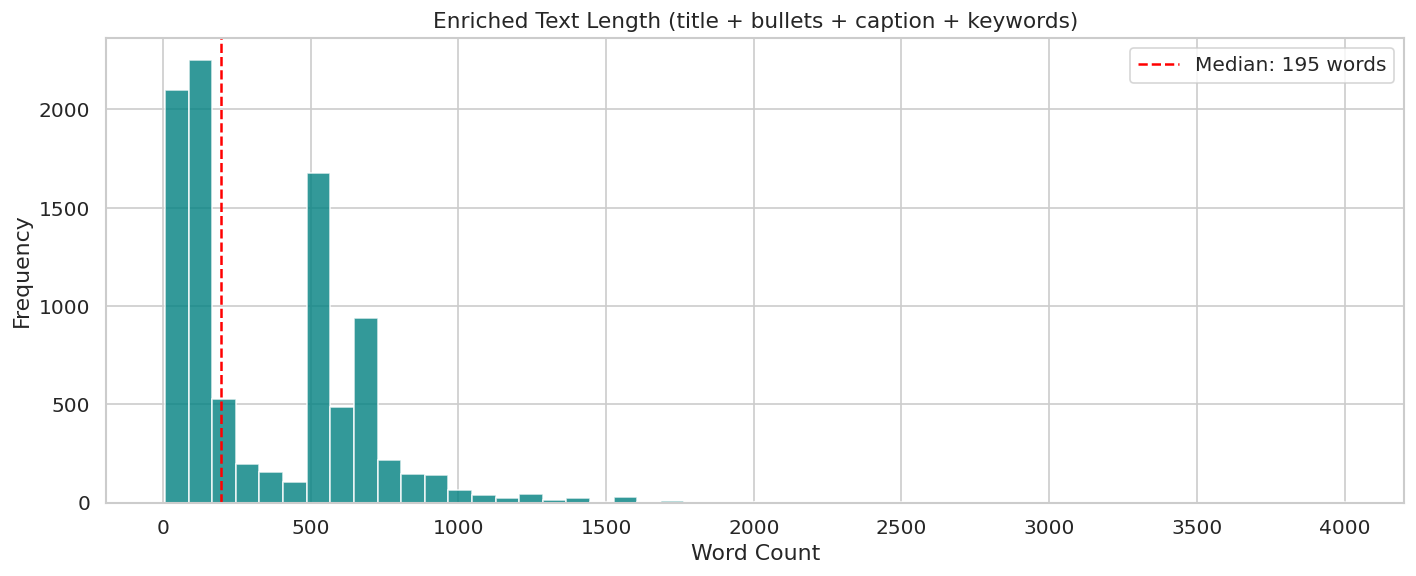

Enriched text stats:
  Mean words:   357
  Median words: 195
  P25 / P75:    96 / 562


In [ ]:
# --- Enriched text length distribution ---
enriched_word_counts = df_enriched["enriched_text"].dropna().apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(enriched_word_counts, bins=50, color="teal", edgecolor="white", alpha=0.8)
ax.axvline(enriched_word_counts.median(), color="red", linestyle="--",
           label=f"Median: {enriched_word_counts.median():.0f} words")
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.set_title("Enriched Text Length (title + bullets + caption + keywords)", fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

print(f"Enriched text stats:")
print(f"  Mean words:   {enriched_word_counts.mean():.0f}")
print(f"  Median words: {enriched_word_counts.median():.0f}")
print(f"  P25 / P75:    {enriched_word_counts.quantile(0.25):.0f} / {enriched_word_counts.quantile(0.75):.0f}")

In [ ]:
import os
import pickle

# ============================================================
# Save all outputs to /kaggle/working/ for the next notebook
# ============================================================
# (Same pattern as 01-shoptalk-eda.ipynb cell 49)

# Define explicit output paths
OUTPUT_DIR = '/kaggle/working/'

ENRICHED_CSV_PATH = os.path.join(OUTPUT_DIR, 'enriched_products.csv')
ENRICHED_PKL_PATH = os.path.join(OUTPUT_DIR, 'enriched_products.pkl')
ENRICHED_FULL_PKL_PATH = os.path.join(OUTPUT_DIR, 'enriched_products_full.pkl')

# Embedding artifacts from Step 5.6
EMBED_INDEX_PATH = os.path.join(OUTPUT_DIR, 'embedding_index.csv')
TEXT_EMB_PATH = os.path.join(OUTPUT_DIR, 'text_embeddings.npy')
IMAGE_EMB_PATH = os.path.join(OUTPUT_DIR, 'image_embeddings.npy')
HYBRID_EMB_PATH = os.path.join(OUTPUT_DIR, 'hybrid_embeddings.npy')

# Select columns for export (clean subset for downstream RAG)
EXPORT_COLS = [
    "item_id", "item_name_flat", "bullet_point_flat", "item_keywords_flat",
    "product_description_flat", "brand_flat", "color_flat", "product_type_flat",
    "main_image_id", "path", "country",
    "image_caption", "detection_confidence", "enriched_text",
]
# Only include columns that exist
export_cols = [c for c in EXPORT_COLS if c in df_enriched.columns]
df_export = df_enriched[export_cols].copy()

print(f"Saving enriched dataset (Shape: {df_export.shape})...")

# 1. Save as Pickle (Recommended – preserves dtypes, lists, NaN)
df_export.to_pickle(ENRICHED_PKL_PATH)
print(f"✓ Saved Pickle: {ENRICHED_PKL_PATH}")

# 2. Save as CSV (Backup for quick inspection)
df_export.to_csv(ENRICHED_CSV_PATH, index=False, escapechar='\\')
print(f"✓ Saved CSV:    {ENRICHED_CSV_PATH}")

# 3. Save FULL enriched DF with all columns (for debugging / deeper analysis)
df_enriched.to_pickle(ENRICHED_FULL_PKL_PATH)
print(f"✓ Saved Full Pickle: {ENRICHED_FULL_PKL_PATH} ({df_enriched.shape[1]} columns)")

# Verify files on disk
print(f"\n✅ Export complete. Files in {OUTPUT_DIR}:")
for fpath in [ENRICHED_PKL_PATH, ENRICHED_CSV_PATH, ENRICHED_FULL_PKL_PATH]:
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {os.path.basename(fpath):35s} {size_mb:.1f} MB")

# Verify embedding artifacts (Step 5.6)
print("\nEmbedding artifacts:")
for fpath in [EMBED_INDEX_PATH, TEXT_EMB_PATH, IMAGE_EMB_PATH, HYBRID_EMB_PATH]:
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {os.path.basename(fpath):35s} {size_mb:.1f} MB")
    else:
        print(f"  {os.path.basename(fpath):35s} MISSING (run Step 5.6)")

# Optional consistency check
if os.path.exists(EMBED_INDEX_PATH) and os.path.exists(HYBRID_EMB_PATH):
    idx_n = len(pd.read_csv(EMBED_INDEX_PATH))
    emb_n = np.load(HYBRID_EMB_PATH, mmap_mode="r").shape[0]
    print(f"\nEmbedding index rows: {idx_n:,}")
    print(f"Hybrid embedding rows: {emb_n:,}")
    if idx_n != emb_n:
        print("⚠️ Mismatch detected between embedding index and vectors.")

print(f"\n📋 Next notebook (03_rag_prototype) should load from:")
print(f"   Text data:    pd.read_pickle('{ENRICHED_PKL_PATH}')")
print(f"   Embed index:  pd.read_csv('{EMBED_INDEX_PATH}')")
print(f"   Hybrid vecs:  np.load('{HYBRID_EMB_PATH}')")

Saving enriched dataset (Shape: (9223, 14))...
✓ Saved Pickle: /kaggle/working/enriched_products.pkl
✓ Saved CSV:    /kaggle/working/enriched_products.csv
✓ Saved Full Pickle: /kaggle/working/enriched_products_full.pkl (51 columns)

✅ Export complete. Files in /kaggle/working/:
  enriched_products.pkl               36.2 MB
  enriched_products.csv               36.0 MB
  enriched_products_full.pkl          74.4 MB

Embedding artifacts:
  embedding_index.csv                 0.4 MB
  text_embeddings.npy                 17.9 MB
  image_embeddings.npy                17.9 MB
  hybrid_embeddings.npy               17.9 MB

Embedding index rows: 9,190
Hybrid embedding rows: 9,190

📋 Next notebook (03_rag_prototype) should load from:
   Text data:    pd.read_pickle('/kaggle/working/enriched_products.pkl')
   Embed index:  pd.read_csv('/kaggle/working/embedding_index.csv')
   Hybrid vecs:  np.load('/kaggle/working/hybrid_embeddings.npy')


In [ ]:
# --- Preview export ---
df_export.head(3)

,item_id,item_name_flat,bullet_point_flat,item_keywords_flat,product_description_flat,brand_flat,color_flat,product_type_flat,main_image_id,path,country,image_caption,detection_confidence,enriched_text
0,B06X9STHNG,"Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,5 UK",Schoen in Loafer-stijl | Platform hak | Cap teen | Middenhak,block heel shoes | loafer shoes | loafers | metallic shoes | womens block heel shoes | womens fashion | womens loafe...,None,find.,Veelkleurig Vrouw Blauw,SHOES,81iZlv3bjpL,8c/8ccb5859.jpg,NL,a product photo of women leather shoes,NaN,"Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,5 UK . Schoen in Loafer-stijl | Platf..."
1,B07P8ML82R,"22"" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs",White Powder Coat Finish | 55-Lbs max weight capacity | Length: 22-inch (550mm) | Set includes 10 pair of slides; en...,22 | Pistola | Montaje bajo | diapositivas | Extensión | Oculto | Deslizadores | Almacenamiento | Bola | Guías | cie...,None,AmazonBasics,White Powder Coat,HARDWARE,619y9YG9cnL,9f/9f76d27b.jpg,MX,a product photo of bottom mount kit for a product,NaN,"22"" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs . White Powder Coat Finish | 55-Lbs max weight capacity ..."
2,B07H9GMYXS,"AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10",3D printer filament with 1.75mm diameter + / - .05mm; designed to fit most common 3D printers (check spool size for ...,3d printer filament | petg printer filament | petg filament | 1.75mm printer filament | 1kg spool printer filament |...,None,AmazonBasics,Translucent Yellow,MECHANICAL_COMPONENTS,81NP7qh2L6L,66/665cc994.jpg,AE,a product photo of petg printer fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi,0.131067,"AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10 . 3D printer filament with 1.75mm di..."


---

## Summary & Key Findings

### Detect-then-Caption Results

| Metric | Value |
|--------|-------|
| Products captioned | 9,190 |
| Success rate | 100.0% |
| **OWL-ViT detection hit rate** | 40.4% (3,711 / 9,190) |
| **Median detection confidence** | 0.163 |
| Median caption length | 9 words |
| Unique captions | 4,337 (47.2%) |
| Throughput | 6.3 img/s (Dual T4) |
| Device | cuda (Tesla T4) x 2 |

### Quality Assessment

1. **Detection Rate:**
    - 40.4%. Observation: The ~60% "misses" are largely clean, white-background product shots where object detection is unnecessary. The fallback to full-image captioning works perfectly for these.
2. **Caption Coverage:**
    - 100%. Every product has a valid visual description, filling the gap for the 97.3% of products missing a product_description.
3. **Diversity:**
    - Observation: High repetition of structures like "case cover for..." is due to the dataset's heavy skew toward mobile accessories. However, the model correctly distinguishes visual variants (colors/patterns) within those categories
4. **Complementarity:**
    - High. Jaccard overlap with bullet points is extremely low (0.037), confirming that captions are adding new visual information (shapes, styles, colors) rather than just repeating technical specs.
5. **CLIP Alignment:**
    - Titles (0.318) > Captions (0.292). Critical Insight: Amazon titles are keyword-stuffed and highly descriptive. Captions score slightly lower but are still high-quality. Conclusion: We must use a Hybrid approach (Title + Caption) because they provide different, complementary signals.

### Implications for RAG Pipeline

- **Enriched text** = `title + bullet_points + image_caption + keywords` (median 195 words).
- Recommended **chunk size**: 512 tokens. (The median length is ~195 words, so 512 tokens provides ample buffer for longer items without excessive fragmentation).
- Image captions **complement** bullet_point text (low vocabulary overlap).
- Products with missing `product_description` (97.3%) now have visual text from captions.
- Strategy Validation: The low vocabulary overlap and distinct CLIP scores confirm that Enriched Text (Text + Caption) + Image Embeddings is the optimal strategy for the final vector search.

### Model Comparison (for Documentation)

| Model | Task | Speed | Notes |
|-------|------|-------|-------|
| OWL-ViT-base | Object Detection | ~15 img/s | Zero-shot detection. Effective at finding objects in lifestyle/cluttered scenes |
| BLIP-base | Captioning | ~20 img/s | Fast and descriptive. "Unconditional" mode works best for cropped images |
| CLIP-base | Similarity | ~X img/s | End-to-end throughput on Dual T4s. Includes overhead of cropping and logic switching |

---

### Next Steps

1. **`03_rag_prototype.ipynb`** (Local) \u2013 Load `enriched_products.csv` into ChromaDB; test RAG retrieval.  
2. **`04_voice_test.ipynb`** (Local) \u2013 Validate Whisper STT.
3. **`05_finetune_llm.ipynb`** (Train LLM to speak about these products)
4. **`06_rag_pipeline.ipynb`** (Build the App. Combine Search + LLM + Voice into the streamlit app.) 
5. **Production ingestion** (`backend/scripts/ingest_abo.py`) \u2013 Use `enriched_text` for embeddings + `image_caption` as metadata.

In [36]:
# ============================================================
# Final Summary (auto-fill)
# ============================================================

print("=" * 60)
print("SHOPTALK DETECT-THEN-CAPTION \u2013 SUMMARY")
print("=" * 60)
print(f"Total Products:          {len(df_enriched):,}")
print(f"Products Captioned:      {df_enriched['image_caption'].notna().sum():,}")
print(f"Caption Success Rate:    {df_enriched['image_caption'].notna().mean():.1%}")

# Detection stats
if "detection_hit" in df_enriched.columns:
    n_cap = df_enriched["image_caption"].notna().sum()
    n_det = df_enriched["detection_hit"].sum()
    print(f"OWL-ViT Detection Hits:  {n_det:,} / {n_cap:,} ({n_det/max(n_cap,1):.1%})")
    print(f"Fallback (Full Image):   {n_cap - n_det:,} ({(n_cap - n_det)/max(n_cap,1):.1%})")
if "detection_confidence" in df_enriched.columns:
    valid_c = df_enriched["detection_confidence"].dropna()
    if len(valid_c) > 0:
        print(f"Median Det. Confidence:  {valid_c.median():.3f}")

if 'caption_word_counts' in dir():
    print(f"Median Caption Words:    {caption_word_counts.median():.0f}")
if 'n_unique' in dir():
    print(f"Unique Captions:         {n_unique:,}")
print(f"Enriched Text Coverage:  {df_enriched['enriched_text'].notna().mean():.1%}")
if 'enriched_word_counts' in dir():
    print(f"Median Enriched Words:   {enriched_word_counts.median():.0f}")
print(f"Device Used:             {DEVICE} ({GPU_NAME})")
print(f"Output Dir:              {OUTPUT_DIR}")
print(f"Output Files:            enriched_products.pkl, enriched_products.csv")
print("=" * 60)
print(f"\n\u2705 Detect-then-caption complete. Proceed to RAG prototype notebook.")
print(f"   Load with: pd.read_pickle('{ENRICHED_PKL_PATH}')")

SHOPTALK DETECT-THEN-CAPTION – SUMMARY
Total Products:          9,223
Products Captioned:      9,190
Caption Success Rate:    99.6%
OWL-ViT Detection Hits:  3,711 / 9,190 (40.4%)
Fallback (Full Image):   5,479 (59.6%)
Median Det. Confidence:  0.163
Median Caption Words:    9
Unique Captions:         4,337
Enriched Text Coverage:  100.0%
Median Enriched Words:   195
Device Used:             cuda (Tesla T4)
Output Dir:              /kaggle/working/
Output Files:            enriched_products.pkl, enriched_products.csv

✅ Detect-then-caption complete. Proceed to RAG prototype notebook.
   Load with: pd.read_pickle('/kaggle/working/enriched_products.pkl')
